# Publication Plots

This notebook contains the plots used for the publication. Data is extracted from the different experiments we discuss.

Content:
- [Sampling](#Sampling)
- [$L_{OR}$ and $E_{OR}$ w.r.t. Variance of Noise in `5j0n`](#$L_{OR}$-and-$E_{OR}$-w.r.t.-Variance-of-Noise-in-5j0n)
- [$L_{OR}$ and $E_{OR}$ w.r.t. Variance of Noise in `5a1a`](#$L_{OR}$-and-$E_{OR}$-w.r.t.-Variance-of-Noise-in-5a1a)
- [Learning from Noisy Projections - projection noise variance $\sigma^2$](#Learning-from-Noisy-Projections---projection-noise-variance-$\sigma^2$)

- [Learning from Shifted Projections - Projection shift limit [px]](#Learning-from-Shifted-Projections---Projection-shift-limit-[px])

- [Learning from different output feature size vector - $n_{f}$](#Learning-from-different-output-feature-size-vector---$n_{f}$)

- [Euclidean vs. Geodesic vs. MLP](#Euclidean-vs.-Geodesic-vs.-MLP)

- [`5j0n` Full-coverage UniformS2 sampling and Noise 0](#5j0n-Full-coverage-UniformS2-sampling-and-Noise-0)

- [`5j0n` Full-coverage UniformS2 sampling and Noise 16](#5j0n-Full-coverage-UniformS2-sampling-and-Noise-16)

- [`5a1a` quarter-coverage UniformS2 sampling and Noise 0 (half-inplane)](#5a1a-quarter-coverage-UniformS2-sampling-and-Noise-0-(half-inplane))

- [`5a1a` quarter-coverage UniformS2 sampling and Noise 0](#5a1a-quarter-coverage-UniformS2-sampling-and-Noise-0)

- [`5j0n` Distance Estimation Loss](#5j0n-Distance-Estimation-Loss)

- [`5a1a` Distance Estimation Loss](#5a1a-Distance-Estimation-Loss)

- [`5j0n` Full-coverage Uniform Euler Angles](#5j0n-Full-coverage-Uniform-Euler-Angles)

- [`5j0n` Full-coverage Uniform S2 Noise 0](#5j0n-Full-coverage-Uniform-S2-Noise-0)

- [`5a1a` Quarter-coverage Uniform S2 Noise 0](#5a1a-Quarter-coverage-Uniform-S2-Noise-0)

- [`5a1a` Full-coverage Uniform S2 Noise 0 trained on quartercov](#5a1a-Full-coverage-Uniform-S2-Noise-0-trained-on-quartercov)

- [`5j0n` Full Coverage Uniform S2 sampling with Noise 0](#5j0n-Full-Coverage-Uniform-S2-sampling-with-Noise-0)

- [`5j0n` Full Coverage Uniform S2 sampling with Noise 16](#5j0n-Full-Coverage-Uniform-S2-sampling-with-Noise-16)

- [`5a1a` Quarter Coverage Uniform S2 sampling with Noise 0 LATEST](#5a1a-Quarter-Coverage-Uniform-S2-sampling-with-Noise-0-LATEST)

- [`5a1a` Quarter Coverage Uniform S2 sampling with Noise 16 LATEST](#5a1a-Quarter-Coverage-Uniform-S2-sampling-with-Noise-16-LATEST)

- [`5j0n` Orientation Recovery Loss $L_{OR}$ Full Coverage - Uniform Angles](#5j0n-Orientation-Recovery-Loss-$L_{OR}$-Full-Coverage---Uniform-Angles)

- [`5a1a` Quarter Coverage Uniform S2 sampling with Perfect distances](#5a1a-Quarter-Coverage-Uniform-S2-sampling-with-Perfect-distances)

- [`5j0n` Projections with Perturbations](#5j0n-Projections-with-Perturbations)

- [Fourier shell correlation (FSCs)](#Fourier-shell-correlation-(FSCs))



In [2]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [3]:
import sys
sys.path.append("../..") 

In [180]:
import os
import h5py
import numpy as np
import time
import pandas as pd


from cryoem.plots import plot_angles_count, plot_images
from IPython.display import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from cryoem.conversions import d_q, euler2quaternion, quaternion2euler
import ipyvolume as ipv
from collections import Counter
import itertools
import seaborn as sns; sns.set(style="whitegrid", color_codes=True)
import io
from cryoem.angle_alignment import training_angle_alignment, update_quaternion

In [5]:
cmap=plt.get_cmap('tab10')

In [6]:
TRAIN_COLOR = cmap(2)
VAL_COLOR = cmap(1)
TEST_COLOR_LOR = cmap(0)
TEST_COLOR_EOR = cmap(3)

In [7]:
ROOT_DIR = ".."
NUM_PROJECTIONS = 5000
INPUT_DATA_DIR  = "../../data/publication_plots_data"
OUTPUT_DATA_DIR = "../../data/publication_plots_figures"

In [8]:
color_cvg1 = u'#1f77b4'
color_cvg2 = u'#ff7f0e'  #u'#2ca02c'

---

# Sampling

In [42]:
tick_size = 18
label_size = 22
legend_size = 20

In [43]:
from cryoem.projections import generate_2D_projections
from cryoem.conversions import euler2quaternion, d_q

In [44]:
firts_time_run = True

In [45]:
if firts_time_run:
    if os.path.exists(f"{INPUT_DATA_DIR}/uniformS2_quaternions_angles_dQ.npz"):
        raise Exception(f"{INPUT_DATA_DIR}/uniformS2_quaternions_angles_dQ.npz File already exists, "+\
                        "manually remove it (so it is definitely your decision) or put firts_time_run=False.")
        
    ProjNber=5000
    generate_2D_projections(input_file_path=f"{INPUT_DATA_DIR}/5j0n.mrc", 
                            ProjNber=ProjNber, 
                            AngCoverage=[2.,1.,2.], # full coverage
                            AngShift=[0.,0.,0.], 
                            Angles=None, 
                            angles_gen_mode="uniform_S2", 
                            output_file_name=f"{INPUT_DATA_DIR}/uniformS2.h5", 
                            dtype=np.float32)
    data = h5py.File(f"{INPUT_DATA_DIR}/uniformS2.h5", 'r')
    angles1 = np.array(data['Angles'], dtype=np.float32)
    quaternions1 = euler2quaternion(angles1)
    
    idx1 = list(np.random.choice(range(ProjNber), size=10000))
    idx2 = list(np.random.choice(range(ProjNber), size=10000))

    q1 = [quaternions1[i] for i in idx1]
    q2 = [quaternions1[i] for i in idx2]
    distances1 = d_q(q1, q2)
    
    np.savez(f"{INPUT_DATA_DIR}/uniformS2_quaternions_angles_dQ.npz", angles=angles1, quaternions=quaternions1, distances=distances1)
    
    if os.path.exists(f"{INPUT_DATA_DIR}/uniformS2.h5"):
        os.remove(f"{INPUT_DATA_DIR}/uniformS2.h5")
else:
    data = np.load(f"{INPUT_DATA_DIR}/uniformS2_quaternions_angles_dQ.npz")
    angles1, quaternions1, distances1 = data['angles'], data['quaternions'], data['distances']

* Generating the dataset *
(5000, 3)
Protein:         5j0n
Input filename:  ../../data/publication_plots_data/5j0n.mrc
Output filename: ../../data/publication_plots_data/uniformS2.h5
Volume:          (69, 57, 75)
Projections (#): (5000, 116, 116)
Angles (#):      (5000, 3)

**********


In [46]:
firts_time_run = True

In [47]:
if firts_time_run:
    if os.path.exists(f"{INPUT_DATA_DIR}/uniformAngles_quaternions_angles_dQ.npz"):
        raise Exception(f"{INPUT_DATA_DIR}/uniformAngles_quaternions_angles_dQ.npz File already exists, "+\
                        "manually remove it (so it is definitely your decision) or put firts_time_run=False.")
        
    ProjNber=5000
    generate_2D_projections(input_file_path=f"{INPUT_DATA_DIR}/5j0n.mrc", 
                            ProjNber=ProjNber, 
                            AngCoverage=[2.,1.,2.], # full coverage
                            AngShift=[0.,0.,0.], 
                            Angles=None, 
                            angles_gen_mode="uniform_angles", 
                            output_file_name=f"{INPUT_DATA_DIR}/uniformAngles.h5", 
                            dtype=np.float32)
    data = h5py.File(f"{INPUT_DATA_DIR}/uniformAngles.h5", 'r')
    angles2 = np.array(data['Angles'], dtype=np.float32)
    quaternions2 = euler2quaternion(angles2)
    
    idx1 = list(np.random.choice(range(ProjNber), size=10000))
    idx2 = list(np.random.choice(range(ProjNber), size=10000))

    q1 = [quaternions2[i] for i in idx1]
    q2 = [quaternions2[i] for i in idx2]
    distances2 = d_q(q1, q2)
    
    np.savez(f"{INPUT_DATA_DIR}/uniformAngles_quaternions_angles_dQ.npz", angles=angles2, quaternions=quaternions2, distances=distances2)
    
    if os.path.exists(f"{INPUT_DATA_DIR}/uniformAngles.h5"):
        os.remove(f"{INPUT_DATA_DIR}/uniformAngles.h5")
else:
    data = np.load(f"{INPUT_DATA_DIR}/uniformAngles_quaternions_angles_dQ.npz")
    angles2, quaternions2, distances2 = data['angles'], data['quaternions'], data['distances']

* Generating the dataset *
(5000, 3)
Protein:         5j0n
Input filename:  ../../data/publication_plots_data/5j0n.mrc
Output filename: ../../data/publication_plots_data/uniformAngles.h5
Volume:          (69, 57, 75)
Projections (#): (5000, 116, 116)
Angles (#):      (5000, 3)

**********


In [48]:
firts_time_run = True

In [49]:
if firts_time_run:
    if os.path.exists(f"{INPUT_DATA_DIR}/uniformAngles_half_quaternions_angles_dQ.npz"):
        raise Exception(f"{INPUT_DATA_DIR}/uniformAngles_half_quaternions_angles_dQ.npz File already exists, "+\
                        "manually remove it (so it is definitely your decision) or put firts_time_run=False.")
        
    ProjNber=5000
    generate_2D_projections(input_file_path=f"{INPUT_DATA_DIR}/5j0n.mrc", 
                            ProjNber=ProjNber, 
                            AngCoverage=[2.,0.4,2.], # full coverage
                            AngShift=[0.,0.,0.], 
                            Angles=None, 
                            angles_gen_mode="uniform_angles", 
                            output_file_name=f"{INPUT_DATA_DIR}/uniformAnglesHalf.h5", 
                            dtype=np.float32)
    data = h5py.File(f"{INPUT_DATA_DIR}/uniformAnglesHalf.h5", 'r')
    angles3 = np.array(data['Angles'], dtype=np.float32)
    quaternions3 = euler2quaternion(angles3)
    
    idx1 = list(np.random.choice(range(ProjNber), size=10000))
    idx2 = list(np.random.choice(range(ProjNber), size=10000))

    q1 = [quaternions3[i] for i in idx1]
    q2 = [quaternions3[i] for i in idx2]
    distances3 = d_q(q1, q2)
    
    np.savez(f"{INPUT_DATA_DIR}/uniformAngles_half_quaternions_angles_dQ.npz", angles=angles3, quaternions=quaternions3, distances=distances3)
    
    if os.path.exists(f"{INPUT_DATA_DIR}/uniformAnglesHalf.h5"):
        os.remove(f"{INPUT_DATA_DIR}/uniformAnglesHalf.h5")
else:
    data = np.load(f"{INPUT_DATA_DIR}/uniformAngles_half_quaternions_angles_dQ.npz")
    angles3, quaternions3, distances3 = data['angles'], data['quaternions'], data['distances']

* Generating the dataset *
(5000, 3)
Protein:         5j0n
Input filename:  ../../data/publication_plots_data/5j0n.mrc
Output filename: ../../data/publication_plots_data/uniformAnglesHalf.h5
Volume:          (69, 57, 75)
Projections (#): (5000, 116, 116)
Angles (#):      (5000, 3)

**********


In [50]:
firts_time_run = True

In [51]:
if firts_time_run:
    if os.path.exists(f"{INPUT_DATA_DIR}/uniformAngles_quarter_quaternions_angles_dQ.npz"):
        raise Exception(f"{INPUT_DATA_DIR}/uniformAngles_quarter_quaternions_angles_dQ.npz File already exists, "+\
                        "manually remove it (so it is definitely your decision) or put firts_time_run=False.")
        
    ProjNber=5000
    generate_2D_projections(input_file_path=f"{INPUT_DATA_DIR}/5a1a.mrc", 
                            ProjNber=ProjNber, 
                            AngCoverage=[1.,.4,1.], # full coverage
                            AngShift=[0.,0.,0.], 
                            Angles=None, 
                            angles_gen_mode="uniform_S2", 
                            output_file_name=f"{INPUT_DATA_DIR}/uniformAnglesQuarter.h5", 
                            dtype=np.float32)
    data = h5py.File(f"{INPUT_DATA_DIR}/uniformAnglesQuarter.h5", 'r')
    angles4 = np.array(data['Angles'], dtype=np.float32)
    quaternions4 = euler2quaternion(angles4)
    
    idx1 = list(np.random.choice(range(ProjNber), size=10000))
    idx2 = list(np.random.choice(range(ProjNber), size=10000))

    q1 = [quaternions4[i] for i in idx1]
    q2 = [quaternions4[i] for i in idx2]
    distances4 = d_q(q1, q2)
    
    np.savez(f"{INPUT_DATA_DIR}/uniformAngles_quarter_quaternions_angles_dQ.npz", angles=angles4, quaternions=quaternions4, distances=distances4)
    
    if os.path.exists(f"{INPUT_DATA_DIR}/uniformAnglesQuarter.h5"):
        os.remove(f"{INPUT_DATA_DIR}/uniformAnglesQuarter.h5")
else:
    data = np.load(f"{INPUT_DATA_DIR}/uniformAngles_quarter_quaternions_angles_dQ.npz")
    angles4, quaternions4, distances4 = data['angles'], data['quaternions'], data['distances']

* Generating the dataset *
(5000, 3)
Protein:         5a1a
Input filename:  ../../data/publication_plots_data/5a1a.mrc
Output filename: ../../data/publication_plots_data/uniformAnglesQuarter.h5
Volume:          (110, 155, 199)
Projections (#): (5000, 275, 275)
Angles (#):      (5000, 3)

**********


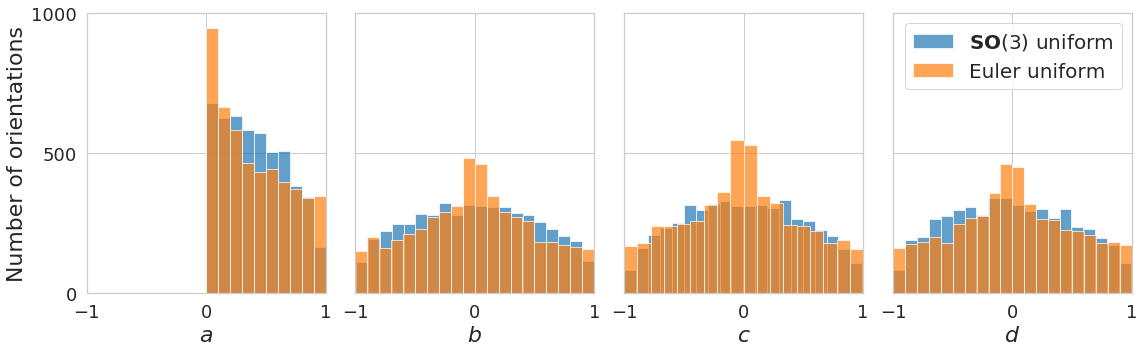

In [52]:
fig, axs = plt.subplots(1, 4, figsize=(16, 5), sharey=True)
#quaternion_color = "lightcoral"
#gs1 = gridspec.GridSpec(4, 13)
#gs1.update(wspace=0.025, hspace=0.05) 
#axs = list(map(lambda i: plt.subplot(gs1[i]), range(4)))
plt.axis('on')
#plt.title("Quaternion: $q = a + b\mathbf{i} + c\mathbf{j} + d\mathbf{k}$", loc='center', fontsize=label_size)
alpha=0.7
bins=20
axs[0].hist(quaternions1[:,3], bins=bins//2, alpha=alpha, color=color_cvg1)
axs[0].hist(quaternions2[:,3], bins=bins//2, alpha=alpha, color=color_cvg2)
axs[0].set_xlabel("$a$", fontsize=label_size)
axs[0].set_ylabel("Number of orientations", fontsize=label_size)
axs[1].hist(quaternions1[:,0], bins=bins, alpha=alpha, color=color_cvg1)
axs[1].hist(quaternions2[:,0], bins=bins, alpha=alpha, color=color_cvg2)
axs[1].set_xlabel("$b$", fontsize=label_size)
axs[2].hist(quaternions1[:,1], bins=bins, alpha=alpha, color=color_cvg1)
axs[2].hist(quaternions2[:,1], bins=bins, alpha=alpha, color=color_cvg2)
axs[2].set_xlabel("$c$", fontsize=label_size)
axs[3].hist(quaternions1[:,2], bins=bins, alpha=alpha, label=r"$\mathbf{SO}(3)$ uniform", color=color_cvg1)
axs[3].hist(quaternions2[:,2], bins=bins, alpha=alpha, label="Euler uniform", color=color_cvg2)
axs[3].set_xlabel("$d$", fontsize=label_size)

axs[0].set_ylim(0,1000)
axs[0].set_xlim(-1,1)
axs[1].set_xlim(-1,1)
axs[2].set_xlim(-1,1)
axs[3].set_xlim(-1,1)
axs[0].yaxis.set_major_locator(plt.MaxNLocator(2))
axs[0].xaxis.set_major_locator(plt.MaxNLocator(steps=[1]))
axs[1].xaxis.set_major_locator(plt.MaxNLocator(steps=[1]))
axs[2].xaxis.set_major_locator(plt.MaxNLocator(steps=[1]))
axs[3].xaxis.set_major_locator(plt.MaxNLocator(steps=[1]))

axs[0].tick_params(axis='both', which='major', labelsize=tick_size)
axs[1].tick_params(axis='both', which='major', labelsize=tick_size)
axs[2].tick_params(axis='both', which='major', labelsize=tick_size)
axs[3].tick_params(axis='both', which='major', labelsize=tick_size)

plt.legend(fontsize=legend_size)
plt.subplots_adjust(wspace=0.001)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DATA_DIR}/uniform_quaternions_vs_angles_q.pdf", pad_inches=1)
plt.show();

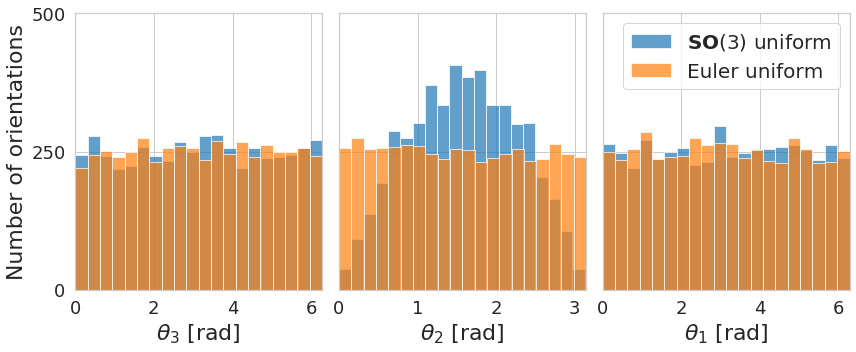

In [53]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5), sharey=True)
#gs1 = gridspec.GridSpec(4, 13)
#gs1.update(wspace=0.025, hspace=0.05) 
#axs = list(map(lambda i: plt.subplot(gs1[i]), range(4)))
plt.axis('on')
#plt.title(r"Euler angles: $\mathbf{\theta} = (\theta_3, \theta_2, \theta_1)$", loc='center')
#angles_color = "darkseagreen"
alpha=0.7
bins=20
axs[0].hist(angles1[:,0]%(2*np.pi), bins=bins, alpha=alpha, color=color_cvg1)
axs[0].hist(angles2[:,0]%(2*np.pi), bins=bins, alpha=alpha, color=color_cvg2)
axs[0].set_xlabel(r"$\theta_3$ [rad]", fontsize=label_size)
axs[0].set_ylabel("Number of orientations", fontsize=label_size)
axs[1].hist(angles1[:,1], bins=bins, alpha=alpha, color=color_cvg1)
axs[1].hist(angles2[:,1], bins=bins, alpha=alpha, color=color_cvg2)
axs[1].set_xlabel(r"$\theta_2$ [rad]", fontsize=label_size)
axs[2].hist(angles1[:,2]%(2*np.pi), bins=bins, alpha=alpha, label=r"$\mathbf{SO}(3)$ uniform", color=color_cvg1)
axs[2].hist(angles2[:,2]%(2*np.pi), bins=bins, alpha=alpha, label="Euler uniform", color=color_cvg2)
axs[2].set_xlabel(r"$\theta_1$ [rad]", fontsize=label_size)

axs[0].set_xlim(0,2*np.pi)
axs[1].set_xlim(0,np.pi)
axs[2].set_xlim(0,2*np.pi)
axs[0].set_ylim(0,500)
axs[0].yaxis.set_major_locator(plt.MaxNLocator(2))
#axs[0].xaxis.set_major_locator(plt.MaxNLocator(steps=[3]))
axs[1].xaxis.set_major_locator(plt.MaxNLocator(steps=[1]))
#axs[2].xaxis.set_major_locator(plt.MaxNLocator(steps=[2]))


axs[0].tick_params(axis='both', which='major', labelsize=tick_size)
axs[1].tick_params(axis='both', which='major', labelsize=tick_size)
axs[2].tick_params(axis='both', which='major', labelsize=tick_size)

plt.legend(fontsize=legend_size)
plt.subplots_adjust(wspace=0.01)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DATA_DIR}/uniform_quaternions_vs_angles_ang.pdf", pad_inches=1)
plt.show();

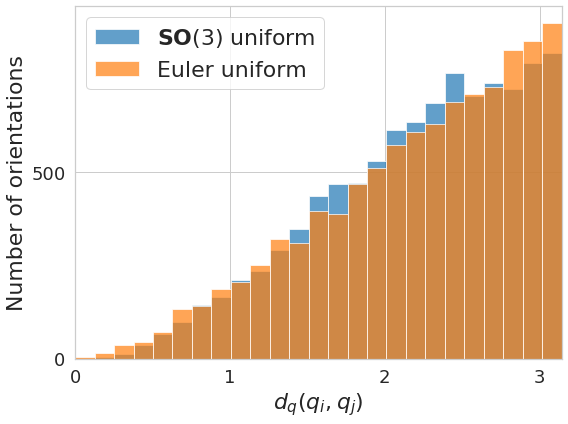

In [54]:
fig, ax = plt.subplots(figsize=(8,6));
alpha=0.7
bins=25
ax.hist(distances1, bins=bins, alpha=alpha, label=r"$\mathbf{SO}(3)$ uniform", color=color_cvg1);
ax.hist(distances2, bins=bins, alpha=alpha, label="Euler uniform", color=color_cvg2);
ax.set_xlim(0, np.pi)
ax.set_xlabel("$d_q(q_i, q_j)$", fontsize=label_size)
ax.set_ylabel("Number of orientations", fontsize=label_size)
ax.yaxis.set_major_locator(plt.MaxNLocator(2))
ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
plt.legend(fontsize=label_size, loc=0)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DATA_DIR}/dQ_5j0n_uniform_quaternions_vs_angles.pdf", pad_inches=1)
plt.show();

In [55]:
tick_size=20
label_size=26

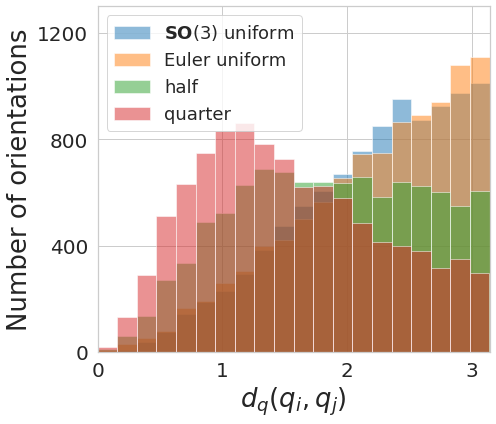

In [56]:
color_cvg1 = u'#1f77b4'
color_cvg2 = u'#ff7f0e'
color_cvg3 = u'#2ca02c'
color_cvg4 = u'#d62728'

fig, ax = plt.subplots(figsize=(7,6));
ax.hist(distances1,bins=20, alpha=0.5, label=r"$\mathbf{SO}(3)$ uniform", color=color_cvg1);  #
ax.hist(distances2,bins=20, alpha=0.5, label="Euler uniform", color=color_cvg2);  #
ax.hist(distances3,bins=20, alpha=0.5, label="half", color=color_cvg3);  #
ax.hist(distances4,bins=20, alpha=0.5, label="quarter", color=color_cvg4);  #

ax.set_xlim(0, np.pi)
ax.set_ylim(0, 1300)
ax.set_xlabel("$d_q(q_i, q_j)$", fontsize=label_size)
ax.set_ylabel("Number of orientations", fontsize=label_size)
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
plt.legend(loc=2, fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DATA_DIR}/dQ_distribution_coverage.pdf", pad_inches=1)
plt.show();

In [59]:
from cryoem.rotation_matrices import RotationMatrix
from scipy.spatial.transform import Rotation as R
import ipyvolume as ipv
from matplotlib.colors import ListedColormap
from matplotlib import cm
import time

def plot_detector_pixels(angles, projections=None, d_p=None, point_size=2, color=None):
    if projections is None:
        angle_ref = angles[0]
        distances = d_q(euler2quaternion(angle_ref), euler2quaternion(angles)).numpy() #[]
    else:
        projection_ref = projections[0]
        print(projection_ref.shape)
        distances = d_p(np.broadcast_to(projection_ref, (len(projections), *projection_ref.shape[-2:])), projections).flatten() #[]
    cmap = plt.cm.get_cmap('viridis', 3)

    colors = list(map(lambda x: cmap(x), distances))

    colormap = cm.coolwarm
    dist_min = 0
    dist_max = np.pi
    znorm = distances - dist_min 
    znorm /= (dist_max - dist_min)
    colorm = colormap(znorm)
    
    # NOTE: used
    ipv.clear()

    if isinstance(angles[0], tf.Variable):
        angles = np.array([a.numpy() for a in angles])

    arr = RotationMatrix(angles)

    ipv.figure(width=500, height=500)
    
    if color is None:
        color = colorm[...,:3]
        s = ipv.scatter(arr[0:1, 0], arr[0:1, 1], arr[0:1, 2],
                marker="sphere", color="black", size=5)

    s = ipv.scatter(arr[:, 0], arr[:, 1], arr[:, 2],
                marker="sphere", color=color, size=point_size)
    
    ipv.xlim(-1, 1)
    ipv.ylim(-1, 1)
    ipv.zlim(-1, 1)
    ipv.show()
    

In [60]:
plot_detector_pixels(angles1, point_size=1.5, color=color_cvg1)

In [61]:
ipv.screenshot()

Output()

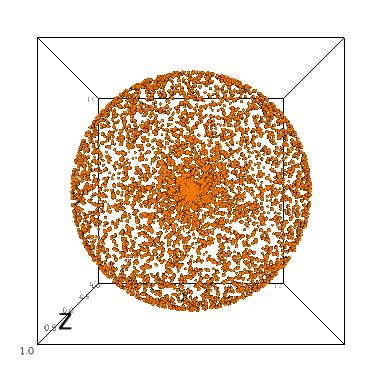

In [62]:
plot_detector_pixels(angles2, point_size=1.5, color=color_cvg2)

In [63]:
ipv.screenshot()

Output()

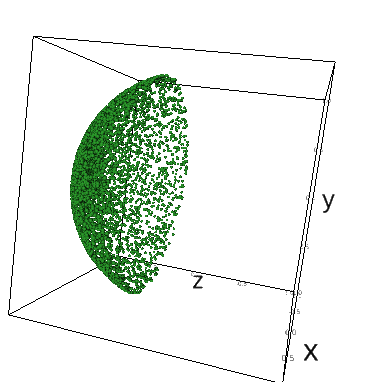

In [65]:
plot_detector_pixels(angles3, point_size=1.5, color=color_cvg3)

In [66]:
ipv.screenshot()

Output()

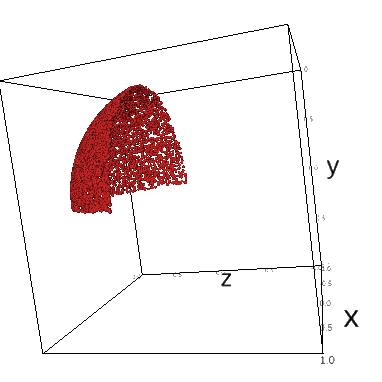

In [68]:
plot_detector_pixels(angles4, point_size=1.5, color=color_cvg4)

In [69]:
ipv.screenshot()

Output()

---

## $L_{OR}$ and $E_{OR}$ w.r.t. Variance of Noise in `5j0n`

In [8]:
labelpad = 6
label_size = 30
tick_size=20

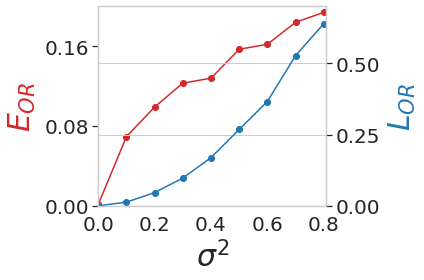

In [9]:
variances = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
losses = np.array([9.26e-09, 1.29e-02, 4.65e-02, 9.74e-02, 1.69e-01, 2.68e-01, 3.66e-01, 5.27e-01, 6.39e-01])
aa_losses = np.array([1.47e-03, 6.94e-02, 9.91e-02, 1.23e-01, 1.28e-01, 1.57e-01, 1.62e-01, 1.84e-01, 1.94e-01])

fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.set_xlabel('$\sigma^2$', fontsize=label_size, labelpad=labelpad)
ax.plot(variances, aa_losses, marker="o", color=TEST_COLOR_EOR)
ax.set_ylabel('$E_{OR}$', color=TEST_COLOR_EOR, fontsize=label_size, labelpad=labelpad)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.set_ylim(0, 0.2)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
ax.grid()
ax.set_xlim(0, 0.81)

ax2 = ax.twinx()
ax2.plot(variances, losses, marker="o", color=TEST_COLOR_LOR)
ax2.set_ylabel('$L_{OR}$', color=TEST_COLOR_LOR, fontsize=label_size, labelpad=labelpad)
ax2.yaxis.set_major_locator(plt.MaxNLocator(3))
ax2.set_ylim(0, 0.7)
ax2.tick_params(axis='both', which='major', labelsize=tick_size)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DATA_DIR}/5j0n_perfect_noisy_ar_aa.pdf")
plt.show()

## $L_{OR}$ and $E_{OR}$ w.r.t. Variance of Noise in `5a1a`

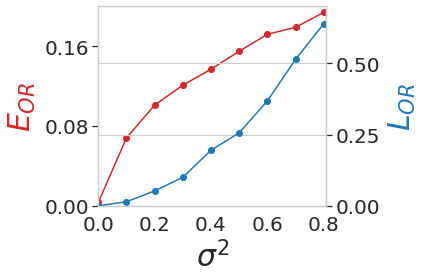

In [10]:
variances = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
losses = np.array([1.42e-08, 1.42e-02, 5.24e-02, 1.00e-01, 1.95e-01, 2.56e-01, 3.68e-01, 5.14e-01, 6.39e-01])
aa_losses = np.array([3.33e-03, 6.81e-02, 1.01e-01, 1.21e-01, 1.37e-01, 1.55e-01, 1.72e-01, 1.79e-01, 1.94e-01])

fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.set_xlabel('$\sigma^2$', fontsize=label_size, labelpad=labelpad)
ax.plot(variances, aa_losses, marker="o", color=TEST_COLOR_EOR)
ax.set_ylabel('$E_{OR}$', color=TEST_COLOR_EOR, fontsize=label_size, labelpad=labelpad)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.set_ylim(0, 0.2)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
ax.grid()
ax.set_xlim(0, 0.81)

ax2 = ax.twinx()
ax2.plot(variances, losses, marker="o", color=TEST_COLOR_LOR)
ax2.set_ylabel('$L_{OR}$', color=TEST_COLOR_LOR, fontsize=label_size, labelpad=labelpad)
ax2.yaxis.set_major_locator(plt.MaxNLocator(3))
ax2.set_ylim(0, 0.7)
ax2.tick_params(axis='both', which='major', labelsize=tick_size)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DATA_DIR}/5a1a_perfect_noisy_ar_aa.pdf")
plt.show()

---

## Learning from Noisy Projections - projection noise variance $\sigma^2$

In [10]:
df0_train = pd.read_csv(f"{INPUT_DATA_DIR}/run-noisy_var0_train-tag-epoch_loss.csv")
df0_train["noise_variance"] = df0_train.apply(lambda x: 0, axis=1)
df0_train["dataset"] = df0_train.apply(lambda x: "train", axis=1)

df0_val = pd.read_csv(f"{INPUT_DATA_DIR}/run-noisy_var0_validation-tag-epoch_loss.csv")
df0_val["noise_variance"] = df0_val.apply(lambda x: 0, axis=1)
df0_val["dataset"] = df0_val.apply(lambda x: "validation", axis=1)

df5_train = pd.read_csv(f"{INPUT_DATA_DIR}/run-noisy_var5_train-tag-epoch_loss.csv")
df5_train["noise_variance"] = df5_train.apply(lambda x: 5, axis=1)
df5_train["dataset"] = df5_train.apply(lambda x: "train", axis=1)

df5_val = pd.read_csv(f"{INPUT_DATA_DIR}/run-noisy_var5_validation-tag-epoch_loss.csv")
df5_val["noise_variance"] = df5_val.apply(lambda x: 5, axis=1)
df5_val["dataset"] = df5_val.apply(lambda x: "validation", axis=1)

df10_train = pd.read_csv(f"{INPUT_DATA_DIR}/run-noisy_var10_train-tag-epoch_loss.csv")
df10_train["noise_variance"] = df10_train.apply(lambda x: 10, axis=1)
df10_train["dataset"] = df10_train.apply(lambda x: "train", axis=1)

df10_val = pd.read_csv(f"{INPUT_DATA_DIR}/run-noisy_var10_validation-tag-epoch_loss.csv")
df10_val["noise_variance"] = df10_val.apply(lambda x: 10, axis=1)
df10_val["dataset"] = df10_val.apply(lambda x: "validation", axis=1)

df16_train = pd.read_csv(f"{INPUT_DATA_DIR}/run-noisy_var16_train-tag-epoch_loss.csv")
df16_train["noise_variance"] = df16_train.apply(lambda x: 16, axis=1)
df16_train["dataset"] = df16_train.apply(lambda x: "train", axis=1)

df16_val = pd.read_csv(f"{INPUT_DATA_DIR}/run-noisy_var16_validation-tag-epoch_loss.csv")
df16_val["noise_variance"] = df16_val.apply(lambda x: 16, axis=1)
df16_val["dataset"] = df16_val.apply(lambda x: "validation", axis=1)

df20_train = pd.read_csv(f"{INPUT_DATA_DIR}/run-noisy_var20_train-tag-epoch_loss.csv")
df20_train["noise_variance"] = df20_train.apply(lambda x: 20, axis=1)
df20_train["dataset"] = df20_train.apply(lambda x: "train", axis=1)

df20_val = pd.read_csv(f"{INPUT_DATA_DIR}/run-noisy_var20_validation-tag-epoch_loss.csv")
df20_val["noise_variance"] = df20_val.apply(lambda x: 20, axis=1)
df20_val["dataset"] = df20_val.apply(lambda x: "validation", axis=1)

df25_train = pd.read_csv(f"{INPUT_DATA_DIR}/run-noisy_var25_train-tag-epoch_loss.csv")
df25_train["noise_variance"] = df25_train.apply(lambda x: 25, axis=1)
df25_train["dataset"] = df25_train.apply(lambda x: "train", axis=1)

df25_val = pd.read_csv(f"{INPUT_DATA_DIR}/run-noisy_var25_validation-tag-epoch_loss.csv")
df25_val["noise_variance"] = df25_val.apply(lambda x: 25, axis=1)
df25_val["dataset"] = df25_val.apply(lambda x: "validation", axis=1)

In [11]:
df = pd.concat([eval(f"df{i}_{d}") for i in [0, 5, 10, 16, 20, 25] for d in ["train", "val"]])

In [12]:
df.dataset.unique()

array(['train', 'validation'], dtype=object)

In [13]:
tick_size = 20
label_size = 27

textbox_size=14.3
small_text = 11
labelpad = 20
fontsize = 20

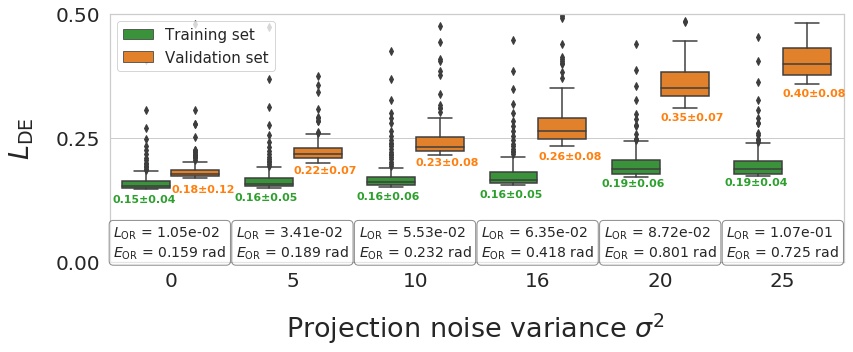

In [15]:
fig, ax = plt.subplots(figsize=(12,5))

df["dataset_full"] = df.dataset.apply(lambda x: "Training set" if x=="train" else "Validation set" if x=="validation" else x)

mapping = {0:0, 1:5, 2:10, 3:16, 4:20, 5:25}
color_map  = {"Training set": TRAIN_COLOR, "Validation set": VAL_COLOR, "": "k"}

box_plot = sns.boxplot(x="noise_variance", y="Value", hue="dataset_full", data=df, ax=ax, palette=color_map)
box_plot.tick_params(labelsize=tick_size)
ax.set_xlabel("Projection noise variance $\sigma^2$ ", fontsize=label_size, labelpad=labelpad);
ax.set_ylabel("$L_\mathrm{DE}$", fontsize=label_size, labelpad=labelpad);
ax.set_ylim(0, 0.5)
ax.legend(loc=2, fontsize=15)
ax.yaxis.set_major_locator(plt.MaxNLocator(4))

medians_na = df[df.dataset=='train'].groupby(['noise_variance'])['Value'].median()
stds_na = df[df.dataset=='train'].groupby(['noise_variance'])['Value'].std()
vertical_offset_na = df[df.dataset=='train']['noise_variance'].median() * 0.004 # offset from median for display
horizontal_offset_na = 0.26

medians = df[df.dataset=='validation'].groupby(['noise_variance'])['Value'].median()
stds = df[df.dataset=='validation'].groupby(['noise_variance'])['Value'].std()
vertical_offset = df[df.dataset=='validation']['noise_variance'].median() * 0.0043 # offset from median for display
horizontal_offset = 0.22


props_red = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.0)
props_blue = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.0)
props = dict(boxstyle='round', edgecolor=TEST_COLOR_LOR, alpha=1.)

Es = [0.1594, 0.1893, 0.2315, 0.4184, 0.8012, 0.7251]
ARs = [1.05e-02, 3.41e-02, 5.53e-02, 6.35e-02, 8.72e-02, 1.07e-01]

for xtick in box_plot.get_xticks():
    margin = 0.019 if xtick<3 else 0.0 if xtick==3 else -0.01
    box_plot.text(
        xtick+horizontal_offset_na, 
        medians[mapping[xtick]] - vertical_offset+margin, 
        f"{medians[mapping[xtick]]:.2f}±{stds_na[mapping[xtick]]:.2f}", 
        horizontalalignment='center', 
        size='x-small', weight='semibold', fontsize=small_text, color=VAL_COLOR)

    ret_val = "$L_\mathrm{OR}$ = "+f"{ARs[xtick]:.2e}" + "\n$E_\mathrm{OR}$ = "+f"{Es[xtick]:.3f} rad"

    box_plot.text(
        0.005+xtick*0.167, 0.15, ret_val, 
        size=textbox_size,
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=14,
        bbox=dict(boxstyle="round", fc="w", ec="k", alpha=0.5))

for xtick in box_plot.get_xticks():
    margin = 0.018 if xtick<6 else -0.01
    box_plot.text(xtick-horizontal_offset, 
                  medians_na[mapping[xtick]] - vertical_offset_na+margin, 
                  f"{medians_na[mapping[xtick]]:.2f}±{stds[mapping[xtick]]:.2f}", 
                  horizontalalignment='center', 
                  size='x-small', weight='semibold', fontsize=small_text, color=TRAIN_COLOR)

ax.yaxis.set_major_locator(plt.MaxNLocator(2))
plt.tight_layout()
plt.savefig(f"{OUTPUT_DATA_DIR}/de_noises_nums.pdf")
plt.show()

---

## Learning from Shifted Projections - Projection shift limit [px]

In [30]:
tick_size = 24
label_size = 27
textbox_size=16
small_text = 12

In [32]:
df0_train = pd.read_csv(f"{INPUT_DATA_DIR}/run-noisy_var0_train-tag-epoch_loss.csv")
df0_train["translation"] = df0_train.apply(lambda x: 0, axis=1)
df0_train["dataset"] = df0_train.apply(lambda x: "train", axis=1)

df0_val = pd.read_csv(f"{INPUT_DATA_DIR}/run-noisy_var0_validation-tag-epoch_loss.csv")
df0_val["translation"] = df0_val.apply(lambda x: 0, axis=1)
df0_val["dataset"] = df0_val.apply(lambda x: "validation", axis=1)

df5_train = pd.read_csv(f"{INPUT_DATA_DIR}/run-translation5_train-tag-epoch_loss.csv")
df5_train["translation"] = df5_train.apply(lambda x: 5, axis=1)
df5_train["dataset"] = df5_train.apply(lambda x: "train", axis=1)

df5_val = pd.read_csv(f"{INPUT_DATA_DIR}/run-translation5_validation-tag-epoch_loss.csv")
df5_val["translation"] = df5_val.apply(lambda x: 5, axis=1)
df5_val["dataset"] = df5_val.apply(lambda x: "validation", axis=1)

df10_train = pd.read_csv(f"{INPUT_DATA_DIR}/run-translation10_train-tag-epoch_loss.csv")
df10_train["translation"] = df10_train.apply(lambda x: 10, axis=1)
df10_train["dataset"] = df10_train.apply(lambda x: "train", axis=1)

df10_val = pd.read_csv(f"{INPUT_DATA_DIR}/run-translation10_validation-tag-epoch_loss.csv")
df10_val["translation"] = df10_val.apply(lambda x: 10, axis=1)
df10_val["dataset"] = df10_val.apply(lambda x: "validation", axis=1)

df15_train = pd.read_csv(f"{INPUT_DATA_DIR}/run-translation15_train-tag-epoch_loss.csv")
df15_train["translation"] = df15_train.apply(lambda x: 15, axis=1)
df15_train["dataset"] = df15_train.apply(lambda x: "train", axis=1)

df15_val = pd.read_csv(f"{INPUT_DATA_DIR}/run-translation15_validation-tag-epoch_loss.csv")
df15_val["translation"] = df15_val.apply(lambda x: 15, axis=1)
df15_val["dataset"] = df15_val.apply(lambda x: "validation", axis=1)

df20_train = pd.read_csv(f"{INPUT_DATA_DIR}/run-translation20_train-tag-epoch_loss.csv")
df20_train["translation"] = df20_train.apply(lambda x: 20, axis=1)
df20_train["dataset"] = df20_train.apply(lambda x: "train", axis=1)

df20_val = pd.read_csv(f"{INPUT_DATA_DIR}/run-translation20_validation-tag-epoch_loss.csv")
df20_val["translation"] = df20_val.apply(lambda x: 20, axis=1)
df20_val["dataset"] = df20_val.apply(lambda x: "validation", axis=1)

In [33]:
df = pd.concat([eval(f"df{i}_{d}") for i in [0, 5, 10, 15, 20] for d in ["train", "val"]])

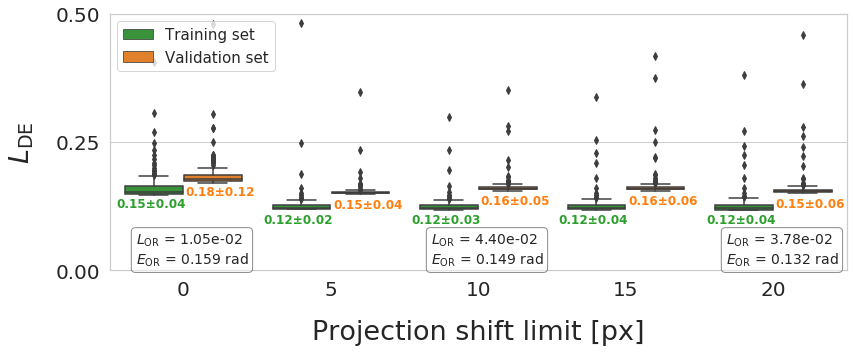

In [36]:
fig, ax = plt.subplots(figsize=(12,5))

df["dataset_full"] = df.dataset.apply(lambda x: "Training set" if x=="train" else "Validation set" if x=="validation" else x)

mapping = {0:0, 1:5, 2:10, 3:15, 4:20}
color_map = {"Training set": TRAIN_COLOR, "Validation set": VAL_COLOR, "": "k"}

box_plot = sns.boxplot(x="translation", y="Value", hue="dataset_full", data=df, ax=ax, palette=color_map)
box_plot.tick_params(labelsize=20)
ax.set_xlabel("Projection shift limit [px]", fontsize=label_size, labelpad=labelpad);
ax.set_ylabel("$L_\mathrm{DE}$", fontsize=label_size, labelpad=labelpad);
ax.set_ylim(0, 0.5)
ax.legend(loc=2, fontsize=15)
ax.yaxis.set_major_locator(plt.MaxNLocator(4))

medians_na = df[df.dataset=='train'].groupby(['translation'])['Value'].median()
stds_na = df[df.dataset=='train'].groupby(['translation'])['Value'].std()
vertical_offset_na = df[df.dataset=='train']['translation'].median() * 0.003 # offset from median for display
horizontal_offset_na = 0.25

medians = df[df.dataset=='validation'].groupby(['translation'])['Value'].median()
stds = df[df.dataset=='validation'].groupby(['translation'])['Value'].std()
vertical_offset = df[df.dataset=='validation']['translation'].median() * 0.003 # offset from median for display
horizontal_offset = 0.22

props_red = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
props_blue = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.5)

Es =  [0.1594,   0.0, 0.14933, 0.0, 0.13211]
ARs = [1.05e-02, 0.0, 0.044,   0.0, 0.0378]

for xtick in box_plot.get_xticks():
    box_plot.text(xtick+horizontal_offset_na, 
                  medians[mapping[xtick]] - vertical_offset, 
                  f"{medians[mapping[xtick]]:.2f}±{stds_na[mapping[xtick]]:.2f}", 
                  horizontalalignment='center', 
                  size='x-small', weight='semibold', fontsize=small_text, color=VAL_COLOR)
    if xtick not in [1, 3]:
        ret_val = "$L_\mathrm{OR}$ = "+f"{ARs[xtick]:.2e}" + "\n$E_\mathrm{OR}$ = "+f"{Es[xtick]:.3f} rad"
        box_plot.text(
            0.035+xtick*0.2, 0.15, ret_val,
            size=textbox_size,
            verticalalignment='top',
            transform=ax.transAxes,
            fontsize=14,
            bbox=dict(boxstyle="round", fc="w", ec="k", alpha=0.5))

for xtick in box_plot.get_xticks():
    box_plot.text(
        xtick-horizontal_offset, 
        medians_na[mapping[xtick]] - vertical_offset_na, 
        f"{medians_na[mapping[xtick]]:.2f}±{stds[mapping[xtick]]:.2f}", 
        horizontalalignment='center', 
        size='x-small', weight='semibold', fontsize=small_text, color=TRAIN_COLOR)
ax.yaxis.set_major_locator(plt.MaxNLocator(2))
plt.tight_layout()
plt.savefig(f"{OUTPUT_DATA_DIR}/de_translation_nums.pdf")
plt.show()

---

## Learning from different output feature size vector - $n_{f}$

In [20]:
df4_train = pd.read_csv(f"{INPUT_DATA_DIR}/run-5j0n_dim4_de_train-tag-epoch_loss.csv")
df4_train["dim"] = df4_train.apply(lambda x: 4, axis=1)
df4_train["dataset"] = df4_train.apply(lambda x: "train", axis=1)

df4_val = pd.read_csv(f"{INPUT_DATA_DIR}/run-5j0n_dim4_de_validation-tag-epoch_loss.csv")
df4_val["dim"] = df4_val.apply(lambda x: 4, axis=1)
df4_val["dataset"] = df4_val.apply(lambda x: "validation", axis=1)

df8_train = pd.read_csv(f"{INPUT_DATA_DIR}/run-5j0n_dim8_de_train-tag-epoch_loss.csv")
df8_train["dim"] = df8_train.apply(lambda x: 8, axis=1)
df8_train["dataset"] = df8_train.apply(lambda x: "train", axis=1)

df8_val = pd.read_csv(f"{INPUT_DATA_DIR}/run-5j0n_dim8_de_validation-tag-epoch_loss.csv")
df8_val["dim"] = df8_val.apply(lambda x: 8, axis=1)
df8_val["dataset"] = df8_val.apply(lambda x: "validation", axis=1)

df16_train = pd.read_csv(f"{INPUT_DATA_DIR}/run-5j0n_dim16_de_train-tag-epoch_loss.csv")
df16_train["dim"] = df16_train.apply(lambda x: 16, axis=1)
df16_train["dataset"] = df16_train.apply(lambda x: "train", axis=1)

df16_val = pd.read_csv(f"{INPUT_DATA_DIR}/run-5j0n_dim16_de_validation-tag-epoch_loss.csv")
df16_val["dim"] = df16_val.apply(lambda x: 16, axis=1)
df16_val["dataset"] = df16_val.apply(lambda x: "validation", axis=1)

df32_train = pd.read_csv(f"{INPUT_DATA_DIR}/run-5j0n_dim32_de_train-tag-epoch_loss.csv")
df32_train["dim"] = df32_train.apply(lambda x: 32, axis=1)
df32_train["dataset"] = df32_train.apply(lambda x: "train", axis=1)

df32_val = pd.read_csv(f"{INPUT_DATA_DIR}/run-5j0n_dim32_de_validation-tag-epoch_loss.csv")
df32_val["dim"] = df32_val.apply(lambda x: 32, axis=1)
df32_val["dataset"] = df32_val.apply(lambda x: "validation", axis=1)

df64_train = pd.read_csv(f"{INPUT_DATA_DIR}/run-5j0n_dim64_de_train-tag-epoch_loss.csv")
df64_train["dim"] = df64_train.apply(lambda x: 64, axis=1)
df64_train["dataset"] = df64_train.apply(lambda x: "train", axis=1)

df64_val = pd.read_csv(f"{INPUT_DATA_DIR}/run-5j0n_dim64_de_validation-tag-epoch_loss.csv")
df64_val["dim"] = df64_val.apply(lambda x: 64, axis=1)
df64_val["dataset"] = df64_val.apply(lambda x: "validation", axis=1)

df128_train = pd.read_csv(f"{INPUT_DATA_DIR}/run-5j0n_dim128_de_train-tag-epoch_loss.csv")
df128_train["dim"] = df128_train.apply(lambda x: 128, axis=1)
df128_train["dataset"] = df128_train.apply(lambda x: "train", axis=1)

df128_val = pd.read_csv(f"{INPUT_DATA_DIR}/run-5j0n_dim128_de_validation-tag-epoch_loss.csv")
df128_val["dim"] = df128_val.apply(lambda x: 128, axis=1)
df128_val["dataset"] = df128_val.apply(lambda x: "validation", axis=1)

df256_train = pd.read_csv(f"{INPUT_DATA_DIR}/run-5j0n_dim256_de_train-tag-epoch_loss.csv")
df256_train["dim"] = df256_train.apply(lambda x: 256, axis=1)
df256_train["dataset"] = df256_train.apply(lambda x: "train", axis=1)

df256_val = pd.read_csv(f"{INPUT_DATA_DIR}/run-5j0n_dim256_de_validation-tag-epoch_loss.csv")
df256_val["dim"] = df256_val.apply(lambda x: 256, axis=1)
df256_val["dataset"] = df256_val.apply(lambda x: "validation", axis=1)

df512_train = pd.read_csv(f"{INPUT_DATA_DIR}/run_train_5j0n_fullcvg_uniformS2-tag-epoch_loss.csv")
df512_train["dim"] = df512_train.apply(lambda x: 512, axis=1)
df512_train["dataset"] = df512_train.apply(lambda x: "train", axis=1)

df512_val = pd.read_csv(f"{INPUT_DATA_DIR}/run_validation_5j0n_fullcvg_uniformS2-tag-epoch_loss.csv")
df512_val["dim"] = df512_val.apply(lambda x: 512, axis=1)
df512_val["dataset"] = df512_val.apply(lambda x: "validation", axis=1)

In [21]:
vals = [4, 8, 16, 32, 128, 256, 512] 
df = pd.concat([eval(f"df{i}_{d}") for i in vals for d in ["train", "val"]])

In [22]:
df.dataset.unique()

array(['train', 'validation'], dtype=object)

In [24]:
# read dP/dQ scatter plot for 4-dimensional embedding
data = np.load(f'{INPUT_DATA_DIR}/dPdQ_data_4d_5j0n.npz')
dP  = data['arr_0']
dQ  = data['arr_1']
df1 = pd.DataFrame(data={"d_P":dP, "d_Q":dQ})

# read dP/dQ scatter plot for 32-dimensional embedding
data = np.load(f'{INPUT_DATA_DIR}/dPdQ_data_32d_5j0n.npz')
dP  = data['arr_0']
dQ  = data['arr_1']
df2 = pd.DataFrame(data={"d_P":dP, "d_Q":dQ})

# read dP/dQ scatter plot for 512-dimensional embedding
data = np.load(f'{INPUT_DATA_DIR}/dPdQ_5j0n_fullcvg_uniformS2_noisy0.npz')
dP  = data['arr_0']
dQ  = data['arr_1']
df3 = pd.DataFrame(data={"d_P":dP, "d_Q":dQ})

In [28]:
tick_size_bigger = 32
label_size_bigger = 45
legend_size=24
tick_size = 20
label_size = 28
textbox_size=14.3
small_text = 20
labelpad = 20
fontsize = 20

/home/jelena/EMAN2/envs/protein_reconstruction/lib/python3.6/site-packages/ipykernel_launcher.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


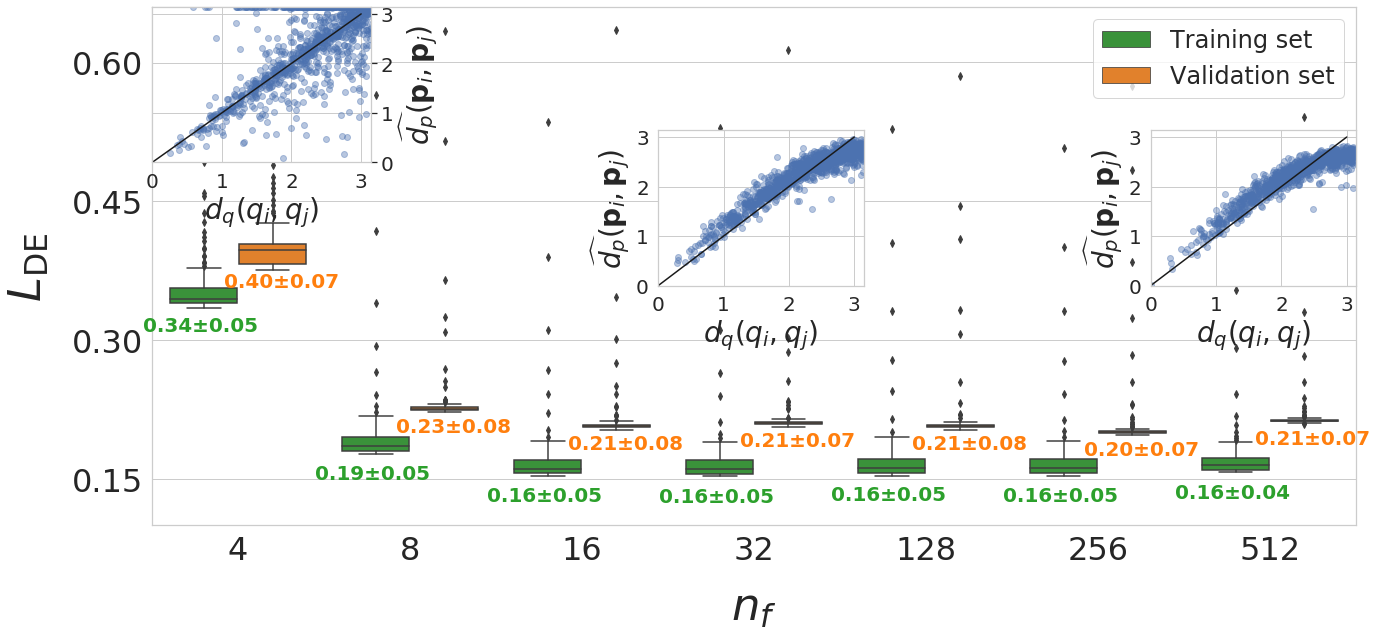

In [29]:
fig = plt.figure(figsize=(19, 9))
ax  = fig.add_axes([0.11, 0.17, 0.88, 0.8])
ax2 = fig.add_axes([0.11, 0.73, 0.16, 0.24], facecolor="white")
ax3 = fig.add_axes([0.48, 0.54, 0.15, 0.24], facecolor="white")
ax4 = fig.add_axes([0.84, 0.54, 0.15, 0.24], facecolor="white")

df["dataset_full"] = df.dataset.apply(lambda x: "Training set" if x=="train" else "Validation set" if x=="validation" else x)

mapping = dict(enumerate(vals))
color_map  = {"Training set": TRAIN_COLOR, "Validation set": VAL_COLOR, "": "k"}

box_plot = sns.boxplot(x="dim", y="Value", hue="dataset_full", data=df, ax=ax, palette=color_map)
box_plot.tick_params(labelsize=tick_size_bigger)
ax.set_xlabel("$n_{f}$ ", fontsize=label_size_bigger, labelpad=labelpad);
ax.set_ylabel("$L_\mathrm{DE}$", fontsize=label_size_bigger, labelpad=labelpad);
ax.set_ylim(0.1, 0.66)
ax.legend(loc=1, fontsize=legend_size)
ax.yaxis.set_major_locator(plt.MaxNLocator(4))

medians_na = df[df.dataset=='train'].groupby(['dim'])['Value'].median()
stds_na = df[df.dataset=='train'].groupby(['dim'])['Value'].std()
vertical_offset_na = df[df.dataset=='train']['dim'].median() * 0.0011 # offset from median for display
horizontal_offset_na = 0.25

medians = df[df.dataset=='validation'].groupby(['dim'])['Value'].median()
stds = df[df.dataset=='validation'].groupby(['dim'])['Value'].std()
vertical_offset = df[df.dataset=='validation']['dim'].median() * 0.0011 # offset from median for display
horizontal_offset = 0.22


props_red = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.0)
props_blue = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.0)
props = dict(boxstyle='round', edgecolor=TEST_COLOR_LOR, alpha=1.)

for xtick in box_plot.get_xticks():
    if xtick==0:
        margin = -0.005
    elif xtick==1:
        margin=0.01
    elif xtick==2:
        margin=0.01
    elif xtick==3:
        margin=0.01
    elif xtick==4:
        margin=0.01
    elif xtick==5:
        margin=0.01
    elif xtick==6:
        margin=0.01
    box_plot.text(xtick+horizontal_offset_na, 
                  medians[mapping[xtick]] - vertical_offset+margin, 
                  f"{medians[mapping[xtick]]:.2f}±{stds_na[mapping[xtick]]:.2f}", 
                  horizontalalignment='center', 
                  size='x-small', weight='semibold', fontsize=small_text, color=VAL_COLOR)

for xtick in box_plot.get_xticks():
    box_plot.text(xtick-horizontal_offset, 
                  medians_na[mapping[xtick]] - vertical_offset_na, 
                  f"{medians_na[mapping[xtick]]:.2f}±{stds[mapping[xtick]]:.2f}", 
                  horizontalalignment='center', 
                  size='x-small', weight='semibold', fontsize=small_text, color=TRAIN_COLOR)

axs_num = 3
for ax_num in range(2, axs_num+2):
    axn = eval(f"ax{ax_num}")
    dfn = eval(f"df{ax_num-1}")
    if ax_num==2:
        ax2.yaxis.tick_right()
        ax2.yaxis.set_label_position("right")
    axn.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
    axn.yaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
    axn.set_xlim(0, np.pi)
    axn.set_ylim(0, np.pi)
    axn.scatter(dfn["d_Q"], dfn["d_P"], color="b", alpha=0.4, label="projection pair");  # "reg", "kde"
    x = np.arange(0, np.pi);
    axn.plot(x, x, color="k")
    axn.set_xlabel("$d_q(q_i, q_j)$", fontsize=label_size)
    axn.set_ylabel("$\widehat{d_p}(\mathbf{p}_i, \mathbf{p}_j)$", fontsize=label_size)
    axn.tick_params(axis='both', which='major', labelsize=tick_size)

ax.yaxis.set_major_locator(plt.MaxNLocator(4))
plt.tight_layout()
plt.savefig(f"{OUTPUT_DATA_DIR}/de_nf.pdf")
plt.show()

---

## Euclidean vs. Geodesic vs. MLP

In [41]:
df_geo_train = pd.read_csv(f"{INPUT_DATA_DIR}/run-cosine_distance_metric_train-tag-epoch_loss.csv")
df_geo_train["distance_metric"] = df_geo_train.apply(lambda x: "Cosine", axis=1)
df_geo_train["dataset"] = df_geo_train.apply(lambda x: "train", axis=1)

df_geo_val = pd.read_csv(f"{INPUT_DATA_DIR}/run-cosine_distance_metric_validation-tag-epoch_loss.csv")
df_geo_val["distance_metric"] = df_geo_val.apply(lambda x: "Cosine", axis=1)
df_geo_val["dataset"] = df_geo_val.apply(lambda x: "validation", axis=1)

df_eucl_train = pd.read_csv(f"{INPUT_DATA_DIR}/run-euclidean_distance_metric_train-tag-epoch_loss.csv")
df_eucl_train["distance_metric"] = df_eucl_train.apply(lambda x: "Euclidean", axis=1)
df_eucl_train["dataset"] = df_eucl_train.apply(lambda x: "train", axis=1)

df_eucl_val = pd.read_csv(f"{INPUT_DATA_DIR}/run-euclidean_distance_metric_validation-tag-epoch_loss.csv")
df_eucl_val["distance_metric"] = df_eucl_val.apply(lambda x: "Euclidean", axis=1)
df_eucl_val["dataset"] = df_eucl_val.apply(lambda x: "validation", axis=1)

In [42]:
df = pd.concat([eval(f"df_{dm}_{ds}") for dm in ["geo", "eucl"] for ds in ["train", "val"]])

In [47]:
# read cosine distance dP/dQ scatter plot
df1 = pd.read_csv(f"{INPUT_DATA_DIR}/dPdQ_cosine_dist.csv")
# read Euclidean distance dP/dQ scatter plot
df2 = pd.read_csv(f"{INPUT_DATA_DIR}/dPdQ_euclidean_dist.csv")

In [48]:
legend_size = 15  #18
legend_size_big = 20
tick_size_bigger = 32
tick_size = 22
label_size_bigger = 45
label_size = 22

textbox_size=22
small_text = 22

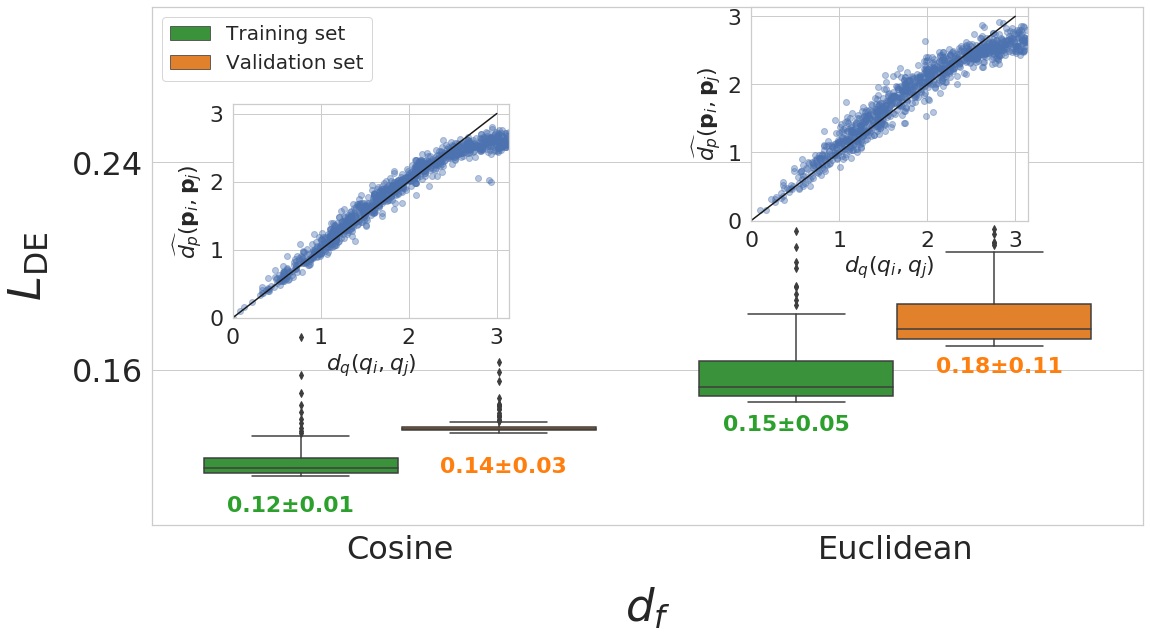

In [49]:
fig = plt.figure(figsize=(16, 9))
ax1 = fig.add_axes([0.13, 0.17, 0.86, 0.8])
ax2 = fig.add_axes([0.2, 0.49, 0.24, 0.33], facecolor="white")
ax3 = fig.add_axes([0.65, 0.64, 0.24, 0.33], facecolor="white")
axs_num = 2
df["dataset_full"] = df.dataset.apply(lambda x: "Training set" if x=="train" else "Validation set" if x=="validation" else x)

mapping = {0:"Cosine", 1:"Euclidean"}  #, 2:"MLP"
color_map  = {"Training set": TRAIN_COLOR, "Validation set": VAL_COLOR, "": "k"}

box_plot = sns.boxplot(x="distance_metric", y="Value", hue="dataset_full", data=df, ax=ax1, palette=color_map)
box_plot.tick_params(labelsize=tick_size_bigger)
ax1.set_xlabel("$d_{f}$", fontsize=label_size_bigger, labelpad=labelpad);
ax1.set_ylabel("$L_\mathrm{DE}$", fontsize=label_size_bigger, labelpad=labelpad);
ax1.set_ylim(0.1, 0.3)
ax1.legend(loc=2, fontsize=legend_size_big)

medians_na = df[df.dataset=='train'].groupby(['distance_metric'])['Value'].median()
stds_na = df[df.dataset=='train'].groupby(['distance_metric'])['Value'].std()
vertical_offset_na = df[df.dataset=='validation']['Value'].median() * 0.1 # offset from median for display
horizontal_offset_na = 0.21
ax1.yaxis.set_major_locator(plt.MaxNLocator(3))
medians = df[df.dataset=='validation'].groupby(['distance_metric'])['Value'].median()
stds = df[df.dataset=='validation'].groupby(['distance_metric'])['Value'].std()
vertical_offset = df[df.dataset=='validation']['Value'].median() * 0.1 # offset from median for display
horizontal_offset = 0.22

for xtick in box_plot.get_xticks():
    box_plot.text(xtick+horizontal_offset_na, 
                  medians[mapping[xtick]] - vertical_offset, 
                  f"{medians[mapping[xtick]]:.2f}±{stds_na[mapping[xtick]]:.2f}", 
                  horizontalalignment='center', 
                  size='x-small', weight='semibold', fontsize=small_text, color=VAL_COLOR)


for xtick in box_plot.get_xticks():
    box_plot.text(xtick-horizontal_offset, 
                  medians_na[mapping[xtick]] - vertical_offset_na, 
                  f"{medians_na[mapping[xtick]]:.2f}±{stds[mapping[xtick]]:.2f}", 
                  horizontalalignment='center', 
                  size='x-small', weight='semibold', fontsize=small_text, color=TRAIN_COLOR)


for ax_num in range(2, axs_num+2):
    axn = eval(f"ax{ax_num}")
    dfn = eval(f"df{ax_num-1}")
    axn.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
    axn.yaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
    axn.set_xlim(0, np.pi)
    axn.set_ylim(0, np.pi)
    axn.scatter(dfn["d_Q"], dfn["d_P"], color="b", alpha=0.4, label="projection pair");  # "reg", "kde"
    x = np.arange(0, np.pi);
    axn.plot(x, x, color="k")
    axn.set_xlabel("$d_q(q_i, q_j)$", fontsize=label_size)
    axn.set_ylabel("$\widehat{d_p}(\mathbf{p}_i, \mathbf{p}_j)$", fontsize=label_size)
    axn.tick_params(axis='both', which='major', labelsize=tick_size)
    

plt.savefig(f"{OUTPUT_DATA_DIR}/dPdQ_feat_distances.pdf", pad_inches=1)

---

## `5j0n` Full-coverage UniformS2 sampling and Noise 0

In [50]:
tick_size = 25
label_size = 35
textbox_size=27
legend_size = 20

In [55]:
data = np.load(f'{INPUT_DATA_DIR}/dPdQ_d5j0n_fullcvg_uniformS2_noisy0.npz')
dP  = data['arr_0']
dQ  = data['arr_1']

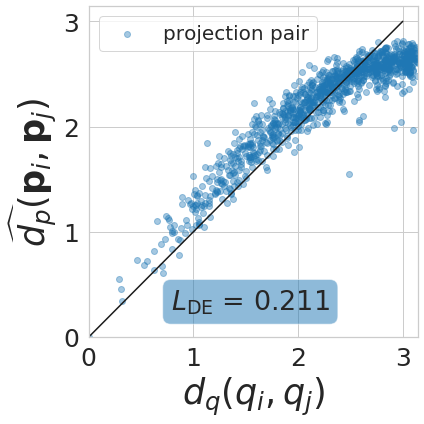

In [57]:
fig, ax = plt.subplots(figsize=(6,6));
plt.scatter(dQ, dP, color=TEST_COLOR_LOR, alpha=0.4, label="projection pair");  # "reg", "kde"
x = np.arange(0, np.pi);
plt.plot(x, x, color="k")
ax.set_xlim(0, np.pi)
ax.set_ylim(0, np.pi)

from tensorflow.keras.losses import KLD, MAE, MSE
MAE(dQ, dP)
props1 = dict(boxstyle='round', facecolor='#1f77b4', alpha=0.5)
ax.text(0.25, 0.15, "$L_\mathrm{DE}$ = "+f"{MAE(dQ, dP):.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)

plt.xlabel("$d_q(q_i, q_j)$", fontsize=label_size)
plt.ylabel("$\widehat{d_p}(\mathbf{p}_i, \mathbf{p}_j)$", fontsize=label_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.legend(loc=2, fontsize=legend_size)
ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
ax.yaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
plt.tight_layout()
plt.savefig(f"{OUTPUT_DATA_DIR}/dPdQ_5j0n_fullcvg_uniformS2_noise0.pdf", pad_inches=1)
plt.show();

In [58]:
variance = np.sqrt(1/(len(dQ)-1)*np.sum(np.power(dP-dQ, 2)))
variance

0.2615634120003712

---

## `5j0n` Full-coverage UniformS2 sampling and Noise 16

In [59]:
tick_size = 18
label_size = 22
textbox_size=22

In [62]:
data = np.load(f'{INPUT_DATA_DIR}/dPdQ_d5j0n_fullcvg_uniformS2_noisy16.npz')
dP  = data['arr_0']
dQ  = data['arr_1']

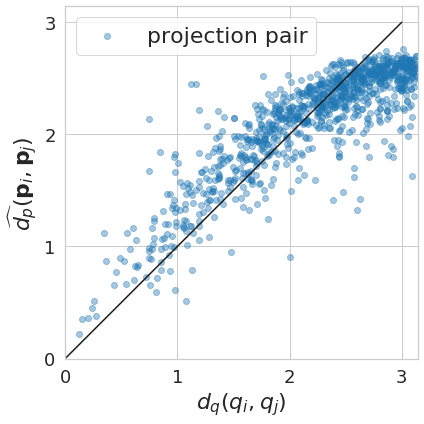

In [63]:
#df1 = pd.read_csv(f"{DATA_DIR}/dP_dQ_5a1a.csv")

#plt.clf();
fig, ax = plt.subplots(figsize=(6,6));
plt.scatter(dQ, dP, color=TEST_COLOR_LOR, alpha=0.4, label="projection pair");  # "reg", "kde"
#sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde", ax=ax[1]);  # "reg", "kde"
x = np.arange(0, np.pi);
plt.plot(x, x, color="k")
ax.set_xlim(0, np.pi)
ax.set_ylim(0, np.pi)
plt.xlabel("$d_q(q_i, q_j)$", fontsize=label_size)
plt.ylabel("$\widehat{d_p}(\mathbf{p}_i, \mathbf{p}_j)$", fontsize=label_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.legend(loc=2, fontsize=label_size)
ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
ax.yaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
plt.tight_layout()
plt.savefig(f"{OUTPUT_DATA_DIR}/dPdQ_5j0n_fullcvg_uniformS2_noise16.pdf", pad_inches=1)
plt.show();

In [64]:
variance = np.sqrt(1/(len(dQ)-1)*np.sum(np.power(dP-dQ, 2)))
variance

0.35805289936047796

---

## `5a1a` quarter-coverage UniformS2 sampling and Noise 0 (half-inplane)

In [65]:
tick_size = 18
label_size = 22
textbox_size=22

In [68]:
data = np.load(f'{INPUT_DATA_DIR}/dPdQ_data_5a1a_quartercvg_uniformS2_noise0_halfInplane.npz')
dP  = data['arr_0']
dQ  = data['arr_1']

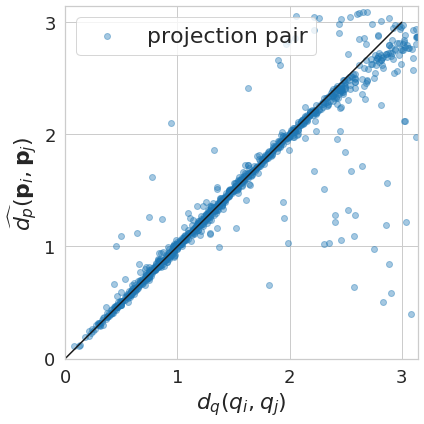

In [70]:
fig, ax = plt.subplots(figsize=(6,6));
plt.scatter(dQ, dP, color=TEST_COLOR_LOR, alpha=0.4, label="projection pair");  # "reg", "kde"
x = np.arange(0, np.pi);
plt.plot(x, x, color="k")
ax.set_xlim(0, np.pi)
ax.set_ylim(0, np.pi)
plt.xlabel("$d_q(q_i, q_j)$", fontsize=label_size)
plt.ylabel("$\widehat{d_p}(\mathbf{p}_i, \mathbf{p}_j)$", fontsize=label_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.legend(loc=2, fontsize=label_size)
ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
ax.yaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
plt.tight_layout()
plt.savefig(f"{OUTPUT_DATA_DIR}/dPdQ_5a1a_quartercvg_uniformS2_noise0_halfInplane.pdf", pad_inches=1)
plt.show();

In [71]:
variance = np.sqrt(1/(len(dQ)-1)*np.sum(np.power(dP-dQ, 2)))
variance

0.2789694589615838

---

## `5a1a` quarter-coverage UniformS2 sampling and Noise 0

In [83]:
tick_size = 25
label_size = 35
textbox_size=27
legend_size = 20

In [84]:
data = np.load(f'{INPUT_DATA_DIR}/dPdQ_data_5a1a_quartercvg_uniformS2_noise0.npz')
dP  = data['arr_0']
dQ  = data['arr_1']

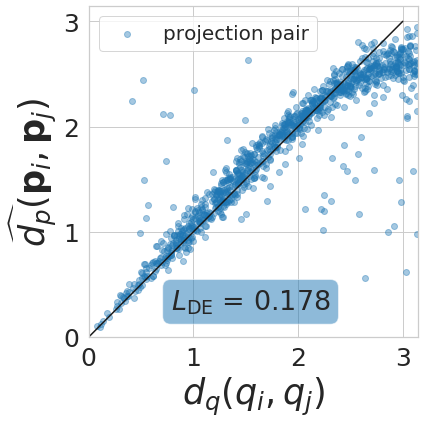

In [85]:
fig, ax = plt.subplots(figsize=(6,6));
plt.scatter(dQ, dP, color=TEST_COLOR_LOR, alpha=0.4, label="projection pair");  # "reg", "kde"
x = np.arange(0, np.pi);
plt.plot(x, x, color="k")
ax.set_xlim(0, np.pi)
ax.set_ylim(0, np.pi)

from tensorflow.keras.losses import KLD, MAE, MSE
MAE(dQ, dP)
props1 = dict(boxstyle='round', facecolor='#1f77b4', alpha=0.5)
ax.text(0.25, 0.15, "$L_\mathrm{DE}$ = "+f"{MAE(dQ, dP):.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)


plt.xlabel("$d_q(q_i, q_j)$", fontsize=label_size)
plt.ylabel("$\widehat{d_p}(\mathbf{p}_i, \mathbf{p}_j)$", fontsize=label_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.legend(loc=2, fontsize=legend_size)
ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
ax.yaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
plt.tight_layout()
plt.savefig(f"{OUTPUT_DATA_DIR}/dPdQ_5a1a_quartercvg_uniformS2_noise0.pdf", pad_inches=1)
plt.show();

In [86]:
variance = np.sqrt(1/(len(dQ)-1)*np.sum(np.power(dP-dQ, 2)))
variance

0.3131353700352579

---

## `5j0n` Distance Estimation Loss

In [88]:
df0_train = pd.read_csv(f"{INPUT_DATA_DIR}/run-noisy_var0_train-tag-epoch_loss.csv")
df0_train["noise_variance"] = df0_train.apply(lambda x: 0, axis=1)
df0_train["dataset"] = df0_train.apply(lambda x: "train", axis=1)

df0_val = pd.read_csv(f"{INPUT_DATA_DIR}/run-noisy_var0_validation-tag-epoch_loss.csv")
df0_val["noise_variance"] = df0_val.apply(lambda x: 0, axis=1)
df0_val["dataset"] = df0_val.apply(lambda x: "validation", axis=1)

In [89]:
tick_size = 26
label_size = 30
textbox_size=30

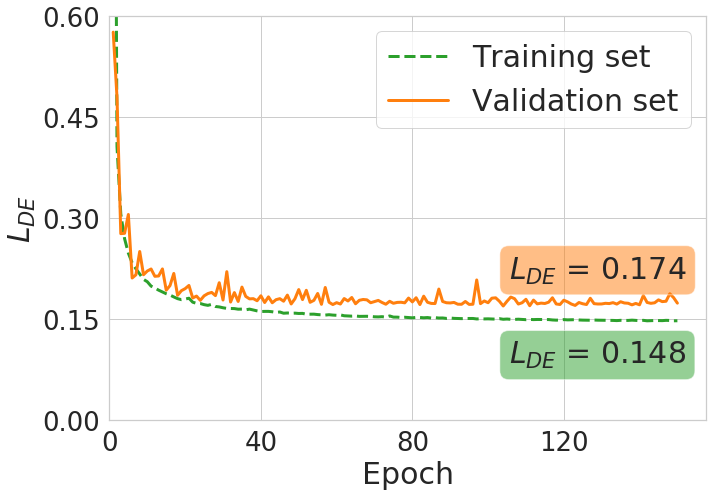

In [91]:
# Get training and test loss histories
training_loss = df0_train['Value'].values
val_loss = df0_val['Value'].values

fig, ax = plt.subplots(figsize=(10,7))

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

props1 = dict(boxstyle='round', facecolor=TRAIN_COLOR, alpha=0.5)
props2 = dict(boxstyle='round', facecolor=VAL_COLOR, alpha=0.5)

# Visualize loss history
ax.plot(epoch_count, training_loss, c=TRAIN_COLOR, ls='--', lw=3, label='Training set')
ax.text(0.67, 0.41, "$L_{DE}$ = "+f"{val_loss[-1]:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
ax.plot(epoch_count, val_loss, c=VAL_COLOR, ls='-', lw=3, label='Validation set')
ax.text(0.67, 0.20, "$L_{DE}$ = "+f"{training_loss[-1]:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)
ax.set_xlabel('Epoch', fontsize=label_size)
ax.set_ylabel('$L_{DE}$', fontsize=label_size)
ax.tick_params(axis='both', which='major', labelsize=tick_size)
ax.legend(loc=1, fontsize=label_size)
ax.set_ylim(0, 0.6)
ax.set_xlim(0)
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
plt.tight_layout()
plt.savefig(f"{OUTPUT_DATA_DIR}/de_5j0n.pdf")

plt.show();

---

## `5a1a` Distance Estimation Loss

In [93]:
tick_size = 26
label_size = 30
textbox_size=30

In [96]:
df0_train = pd.read_csv(f"{INPUT_DATA_DIR}/run-noisy_var0_5a1a_train-tag-epoch_loss.csv")
df0_train["noise_variance"] = df0_train.apply(lambda x: 0, axis=1)
df0_train["dataset"] = df0_train.apply(lambda x: "train", axis=1)

df0_val = pd.read_csv(f"{INPUT_DATA_DIR}/run-noisy_var0_5a1a_validation-tag-epoch_loss.csv")
df0_val["noise_variance"] = df0_val.apply(lambda x: 0, axis=1)
df0_val["dataset"] = df0_val.apply(lambda x: "validation", axis=1)

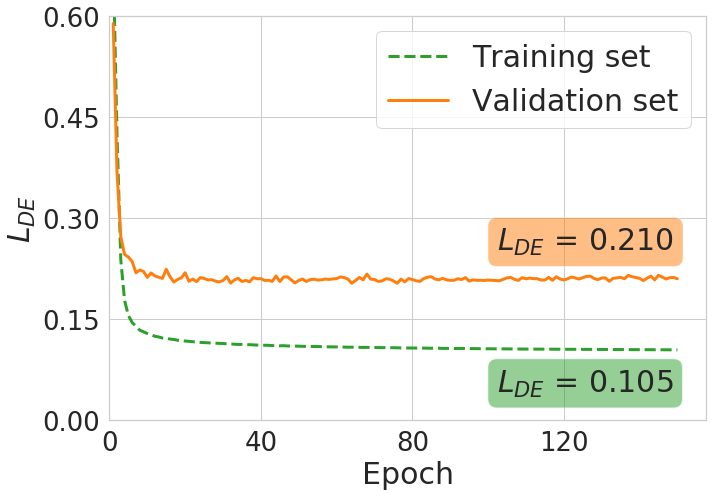

In [98]:
# Get training and test loss histories
training_loss = df0_train['Value'].values[78:228]
val_loss = df0_val['Value'].values[78:228]

fig, ax = plt.subplots(figsize=(10,7))

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

props1 = dict(boxstyle='round', facecolor=TRAIN_COLOR, alpha=0.5)
props2 = dict(boxstyle='round', facecolor=VAL_COLOR, alpha=0.5)

# Visualize loss history
ax.plot(epoch_count, training_loss, c=TRAIN_COLOR, ls='--', lw=3, label='Training set')
ax.text(0.65, 0.48, "$L_{DE}$ = "+f"{val_loss[-1]:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
ax.plot(epoch_count, val_loss, c=VAL_COLOR, ls='-', lw=3, label='Validation set')
ax.text(0.65, 0.13, "$L_{DE}$ = "+f"{training_loss[-1]:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)
ax.set_xlabel('Epoch', fontsize=label_size)
ax.set_ylabel('$L_{DE}$', fontsize=label_size)
ax.tick_params(axis='both', which='major', labelsize=tick_size)
ax.set_ylim(0, 0.6)
ax.set_xlim(0)
ax.legend(loc=1, fontsize=label_size)
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
plt.tight_layout()
plt.savefig(f"{OUTPUT_DATA_DIR}/de_5a1a.pdf")
plt.show();

## `5j0n` Full-coverage Uniform Euler Angles

In [100]:
tick_size = 26
label_size = 30
textbox_size=30

In [102]:
df0_train = pd.read_csv(f"{INPUT_DATA_DIR}/run_train-tag-epoch_loss.csv")
df0_train["noise_variance"] = df0_train.apply(lambda x: 0, axis=1)
df0_train["dataset"] = df0_train.apply(lambda x: "train", axis=1)

df0_val = pd.read_csv(f"{INPUT_DATA_DIR}/run_validation-tag-epoch_loss.csv")
df0_val["noise_variance"] = df0_val.apply(lambda x: 0, axis=1)
df0_val["dataset"] = df0_val.apply(lambda x: "validation", axis=1)

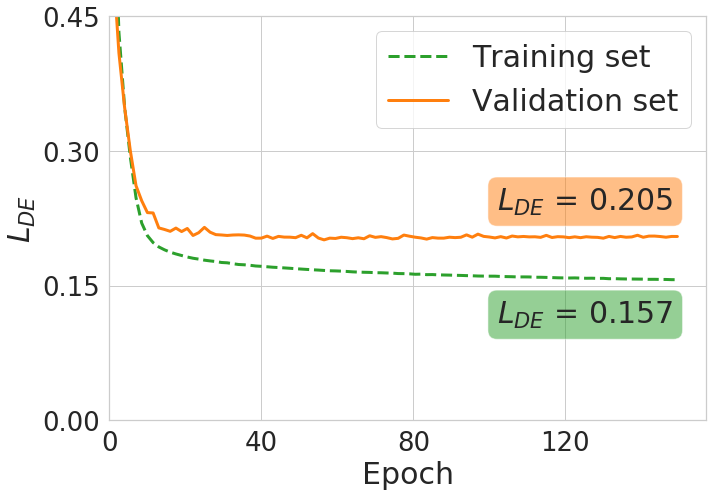

In [104]:
# Get training and test loss histories
training_loss = df0_train['Value'].values
val_loss = df0_val['Value'].values

fig, ax = plt.subplots(figsize=(10,7))

# Create count of the number of epochs
epoch_count = np.arange(1, 150, 1.5)#len(training_loss) + 1)

props1 = dict(boxstyle='round', facecolor=TRAIN_COLOR, alpha=0.5)
props2 = dict(boxstyle='round', facecolor=VAL_COLOR, alpha=0.5)

# Visualize loss history
ax.plot(epoch_count, training_loss, c=TRAIN_COLOR, ls='--', lw=3, label='Training set')
ax.text(0.65, 0.58, "$L_{DE}$ = "+f"{val_loss[-1]:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
ax.plot(epoch_count, val_loss, c=VAL_COLOR, ls='-', lw=3, label='Validation set')
ax.text(0.65, 0.3, "$L_{DE}$ = "+f"{training_loss[-1]:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)
ax.set_xlabel('Epoch', fontsize=label_size)
ax.set_ylabel('$L_{DE}$', fontsize=label_size)
ax.tick_params(axis='both', which='major', labelsize=tick_size)
ax.set_ylim(0, 0.45)
ax.set_xlim(0)
ax.legend(loc=1, fontsize=label_size)
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
plt.tight_layout()
plt.savefig(f"{OUTPUT_DATA_DIR}/de_5j0n_fullcov.pdf")
plt.show();

## `5j0n` Full-coverage Uniform S2 Noise 0

In [105]:
tick_size = 30
label_size = 45
textbox_size=35
legend_size = 30

In [106]:
df0_train = pd.read_csv(f"{INPUT_DATA_DIR}/run_train_5j0n_fullcvg_uniformS2-tag-epoch_loss.csv")
df0_train["noise_variance"] = df0_train.apply(lambda x: 0, axis=1)
df0_train["dataset"] = df0_train.apply(lambda x: "train", axis=1)

df0_val = pd.read_csv(f"{INPUT_DATA_DIR}/run_validation_5j0n_fullcvg_uniformS2-tag-epoch_loss.csv")
df0_val["noise_variance"] = df0_val.apply(lambda x: 0, axis=1)
df0_val["dataset"] = df0_val.apply(lambda x: "validation", axis=1)

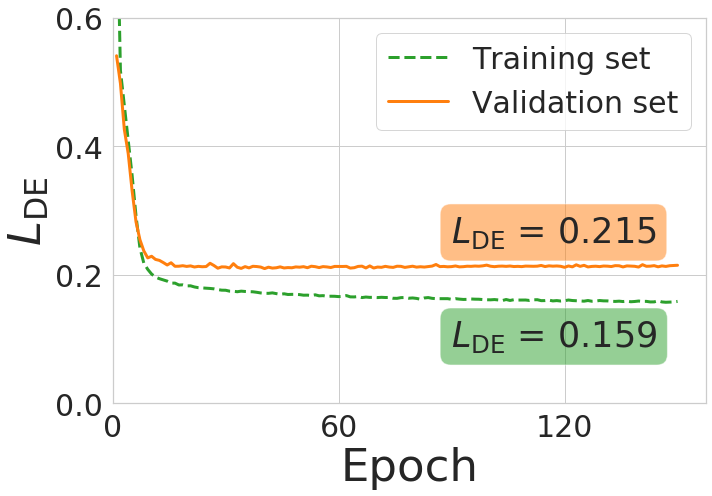

In [108]:
# Get training and test loss histories
training_loss = df0_train['Value'].values#[78:228]
val_loss = df0_val['Value'].values#[78:228]

fig, ax = plt.subplots(figsize=(10,7))

# Create count of the number of epochs
epoch_count = np.linspace(1, 150, 145)#len(training_loss) + 1)

props1 = dict(boxstyle='round', facecolor=TRAIN_COLOR, alpha=0.5)
props2 = dict(boxstyle='round', facecolor=VAL_COLOR, alpha=0.5)

# Visualize loss history
ax.plot(epoch_count, training_loss, c=TRAIN_COLOR, ls='--', lw=3, label='Training set')
ax.text(0.57, 0.49, "$L_\mathrm{DE}$ = "+f"{val_loss[-1]:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
ax.plot(epoch_count, val_loss, c=VAL_COLOR, ls='-', lw=3, label='Validation set')
ax.text(0.57, 0.22, "$L_\mathrm{DE}$ = "+f"{training_loss[-1]:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)
ax.set_xlabel('Epoch', fontsize=label_size)
ax.set_ylabel('$L_\mathrm{DE}$', fontsize=label_size)
ax.tick_params(axis='both', which='major', labelsize=tick_size)
ax.set_ylim(0, 0.6)
ax.set_xlim(0)
ax.legend(loc=1, fontsize=legend_size)
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
plt.tight_layout()
plt.savefig(f"{OUTPUT_DATA_DIR}/de_5j0n_fullcov_uniformS2.pdf")
plt.show();

## `5a1a` Quarter-coverage Uniform S2 Noise 0

In [125]:
tick_size = 30
label_size = 45
textbox_size=35
legend_size = 30

In [126]:
df0_train = pd.read_csv(f"{INPUT_DATA_DIR}/5a1a_quartercvg_uniformS2_noise0_halfInplane-run-train-tag-epoch_loss.csv")
df0_train["noise_variance"] = df0_train.apply(lambda x: 0, axis=1)
df0_train["dataset"] = df0_train.apply(lambda x: "train", axis=1)

df0_val = pd.read_csv(f"{INPUT_DATA_DIR}/5a1a_quartercvg_uniformS2_noise0_halfInplane-run-validation-tag-epoch_loss.csv")
df0_val["noise_variance"] = df0_val.apply(lambda x: 0, axis=1)
df0_val["dataset"] = df0_val.apply(lambda x: "validation", axis=1)

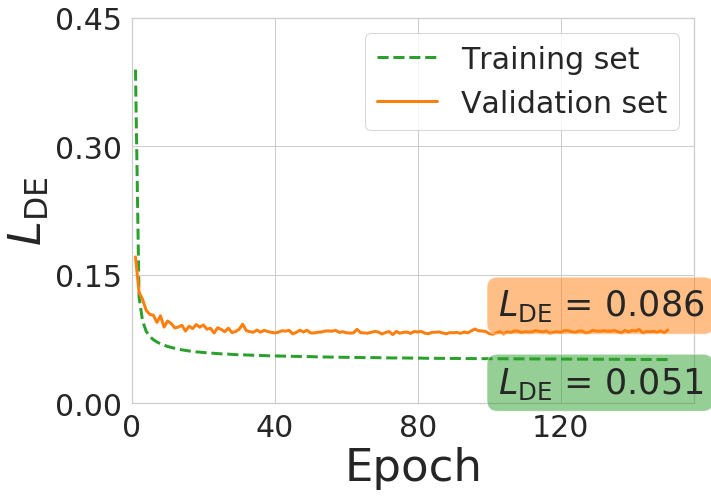

In [113]:
# Get training and test loss histories
training_loss = df0_train['Value'].values#[78:228]
val_loss = df0_val['Value'].values#[78:228]

fig, ax = plt.subplots(figsize=(10,7))

# Create count of the number of epochs
epoch_count = np.linspace(1, 150, 150)#len(training_loss) + 1)

props1 = dict(boxstyle='round', facecolor=TRAIN_COLOR, alpha=0.5)
props2 = dict(boxstyle='round', facecolor=VAL_COLOR, alpha=0.5)

# Visualize loss history
ax.plot(epoch_count, training_loss, c=TRAIN_COLOR, ls='--', lw=3, label='Training set')
ax.text(0.65, 0.3, "$L_\mathrm{DE}$ = "+f"{val_loss[-1]:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
ax.plot(epoch_count, val_loss, c=VAL_COLOR, ls='-', lw=3, label='Validation set')
ax.text(0.65, 0.1, "$L_\mathrm{DE}$ = "+f"{training_loss[-1]:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)
ax.set_xlabel('Epoch', fontsize=label_size)
ax.set_ylabel('$L_\mathrm{DE}$', fontsize=label_size)
ax.tick_params(axis='both', which='major', labelsize=tick_size)
ax.set_ylim(0, 0.45)
ax.set_xlim(0)
ax.legend(loc=1, fontsize=legend_size)
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
plt.tight_layout()
plt.savefig(f"{OUTPUT_DATA_DIR}/de_5a1a_quartercov_uniformS2.pdf")
plt.show();

## `5a1a` Full-coverage Uniform S2 Noise 0 trained on quartercov

In [132]:
df0_train = pd.read_csv(f"{INPUT_DATA_DIR}/5a1a_fullcvg_uniformS2_noise0-run-train-tag-epoch_loss.csv")
df0_train["noise_variance"] = df0_train.apply(lambda x: 0, axis=1)
df0_train["dataset"] = df0_train.apply(lambda x: "train", axis=1)

# df0_val = pd.DataFrame(data={"Value":vals, "Step":np.linspace(1, 150, 99)})
# df0_val.to_csv(f"{INPUT_DATA_DIR}/5a1a_fullcvg_uniformS2_noise0-run-validation-tag-epoch_loss.csv")
df0_val = pd.read_csv(f"{INPUT_DATA_DIR}/5a1a_fullcvg_uniformS2_noise0-run-validation-tag-epoch_loss.csv")
df0_val["noise_variance"] = df0_val.apply(lambda x: 0, axis=1)
df0_val["dataset"] = df0_val.apply(lambda x: "validation", axis=1)

In [133]:
tick_size = 30
label_size = 45
textbox_size=35
legend_size = 30

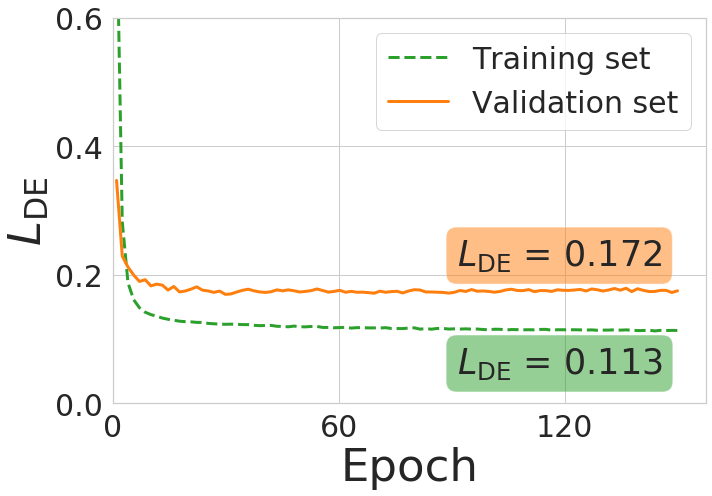

In [136]:
# Get training and test loss histories
training_loss = df0_train['Value'].values
val_loss = df0_val['Value'].values
epoch_count = df0_val['Step'].values

fig, ax = plt.subplots(figsize=(10,7))

props1 = dict(boxstyle='round', facecolor=TRAIN_COLOR, alpha=0.5)
props2 = dict(boxstyle='round', facecolor=VAL_COLOR, alpha=0.5)

# Visualize loss history
ax.plot(epoch_count, training_loss, c=TRAIN_COLOR, ls='--', lw=3, label='Training set')
ax.text(0.58, 0.43, "$L_\mathrm{DE}$ = "+f"{val_loss[-2]:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
ax.plot(epoch_count, val_loss, c=VAL_COLOR, ls='-', lw=3, label='Validation set')
ax.text(0.58, 0.15, "$L_\mathrm{DE}$ = "+f"{training_loss[-1]:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)
ax.set_xlabel('Epoch', fontsize=label_size)
ax.set_ylabel('$L_\mathrm{DE}$', fontsize=label_size)
ax.tick_params(axis='both', which='major', labelsize=tick_size)
ax.set_ylim(0, 0.6)
ax.set_xlim(0)
ax.legend(loc=1, fontsize=legend_size)
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
plt.tight_layout()
plt.savefig(f"{OUTPUT_DATA_DIR}/de_5a1a_last.pdf")
plt.show();

---

## `5j0n` Full Coverage Uniform S2 sampling with Noise 0

#### Collecting data for plots example

In [9]:
PROTEIN="5j0n"
projections_filename = f"{INPUT_DATA_DIR}/results_pipeline_5j0n_fullcvg_uniformS2_noise0/5j0n_uniform_ProjectionsAngles_ProjNber5000_AngCoverage2.0,1.0,2.0_AngShift0.0,0.0,0.0.h5"
data = h5py.File(projections_filename, 'r')
angles_true = data['Angles']

data = np.load(f"{INPUT_DATA_DIR}/results_pipeline_5j0n_fullcvg_uniformS2_noise0/5j0n_siamese_idx.npz")
train_idx, val_idx, test_idx = data['arr_0'], data['arr_1'], data['arr_2']

data = np.load(f"{INPUT_DATA_DIR}/results_pipeline_5j0n_fullcvg_uniformS2_noise0/angle_recovery.npz")
q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

angles_predicted = quaternion2euler(q_predicted)
angles_predicted.shape

TensorShape([1650, 3])

In [14]:
losses_plot = losses[:14490]
np.savetxt(f'{INPUT_DATA_DIR}/5j0n_LOR_fullcvg_uniformS2_noise0.csv', losses_plot)

In [16]:
from cryoem.angle_alignment import training_angle_alignment, update_quaternion
from tensorflow.keras.optimizers import Adagrad, Ftrl

m= [1.0, 1.0, 1.0, 1.0] 
trajectory_first= [4.46876821 5.19836847 1.77256393 4.79171568 0.59308777 3.54493704] 
loss_first= 2.123662027780452 
trajectory_last= [ 45.57891446  22.93904469 -15.69086015   7.4149353  -12.91150917
   7.22542069] 
loss_last= 0.21779469250103844


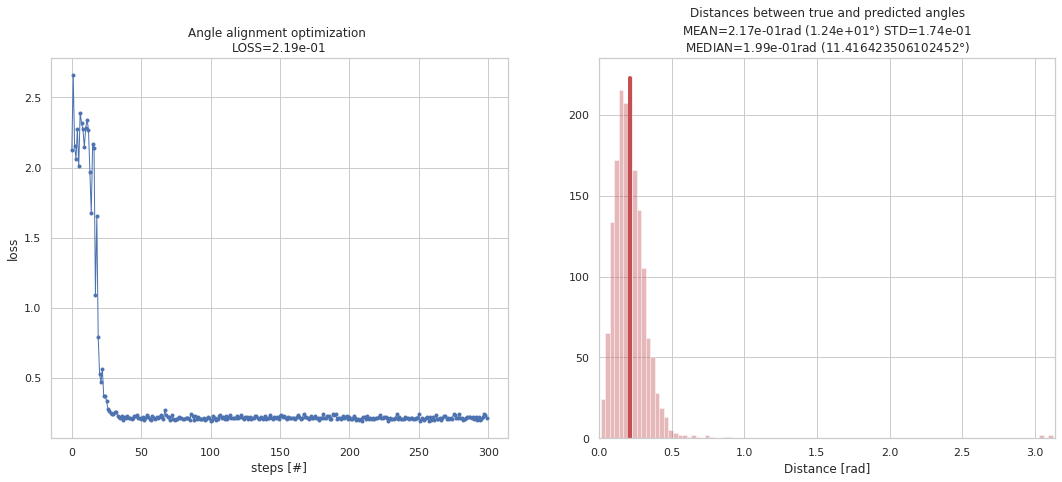

In [17]:
m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
                                                        steps=300, 
                                                        batch_size=256, 
                                                        optimizer=Ftrl(learning_rate=2., learning_rate_power=-2.), 
                                                        angles_true=np.array(angles_true)[test_idx], 
                                                        angles_predicted=angles_predicted.numpy())

In [23]:
m= [1.0, 1.0, 1.0, 1.0] 
trajectory_first= [4.46876821, 5.19836847 ,1.77256393, 4.79171568, 0.59308777, 3.54493704] 
loss_first= 2.123662027780452 
trajectory_last= [ 45.57891446 , 22.93904469, -15.69086015  , 7.4149353 , -12.91150917, 7.22542069] 
loss_last= 0.19925397433019346

Text(0.02, 0.97, '$E$ = 0.1993 rad')

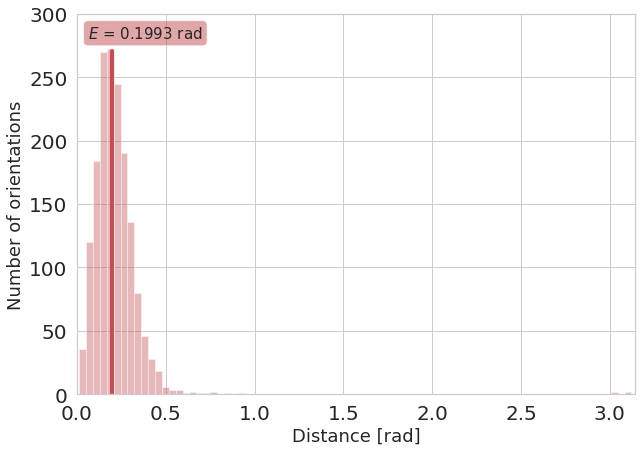

In [29]:
# Distance count subplot (full)
q_predicted_rot = update_quaternion(m, [tf.Variable(trajectory_last)], q_predicted, dtype=tf.float64)

d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
#save just the data for the plot, not the whole pipeline
np.savetxt(f'{INPUT_DATA_DIR}/5j0n_EOR_fullcvg_uniformS2_noise0.csv', d2)

fig, ax = plt.subplots(figsize=(10,7))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 300)
s = sns.distplot(d2, kde=False, bins=80, ax=ax, color="r")
max_count = int(max([h.get_height() for h in s.patches]))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)

props = dict(boxstyle='round', facecolor='r', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.02, 0.97, f"$E$ = {loss_last:.4f} rad", transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props)

#### Plotting data

In [156]:
# these 2 files and a loss are from above
losses_plot = np.loadtxt(f'{INPUT_DATA_DIR}/5j0n_LOR_fullcvg_uniformS2_noise0.csv')
d2 = np.loadtxt(f'{INPUT_DATA_DIR}/5j0n_EOR_fullcvg_uniformS2_noise0.csv')
loss_last= 0.19925397433019346

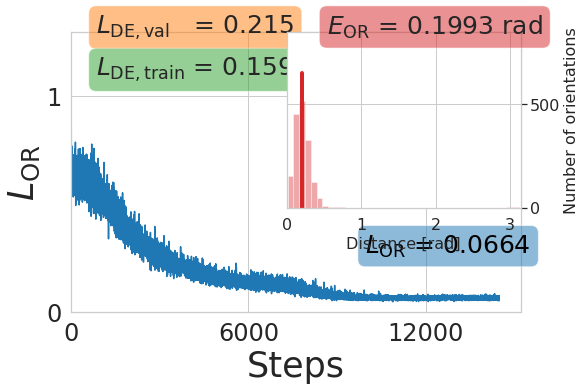

In [158]:
tick_size = 24
tick_size_small = 16
label_size = 35
textbox_size=25
label_size_small = 16

props1 = dict(boxstyle='round', facecolor=TRAIN_COLOR, alpha=0.5)
props2 = dict(boxstyle='round', facecolor=VAL_COLOR, alpha=0.5)


fig = plt.figure(figsize=(8, 5))
ax1 = fig.add_axes([0.11, 0.2, 0.78, 0.78])
ax2 = fig.add_axes([0.484, 0.49, 0.406, 0.49], facecolor="white")

ax1.plot(losses_plot, c=TEST_COLOR_LOR) 
ax1.set_xlabel("Steps", fontsize=label_size)
ax1.set_ylabel("$L_\mathrm{OR}$", fontsize=label_size)

ax1.set_xlim(0)
ax1.set_ylim(0,1.3)
#ax1.patch.set_facecolor("white")
ax1.xaxis.set_major_locator(plt.MaxNLocator(3))
ax1.yaxis.set_major_locator(plt.MaxNLocator(1))

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.5)
# place a text box in upper left in axes coords
ax1.text(0.42, 0.16, "$L_\mathrm{OR}$ = "+f"{np.mean(losses_plot[-10:]):.4f}", color="black", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
ax1.tick_params(axis='both', which='major', labelsize=tick_size)

### histogram
ax2.set_xlim(0, np.pi);ax2.set_ylim(0, 850)
# plot histogram
s = sns.distplot(d2, kde=False, bins=40, ax=ax2, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
# plot median line
ax2.plot([np.median(d2)]*max_count, np.linspace(0, 650,max_count), c=TEST_COLOR_EOR, lw=4)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_xlabel("Distance [rad]", fontsize=label_size_small)
ax2.set_ylabel("Number of orientations", fontsize=label_size_small)
# We change the fontsize of minor ticks label 
props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax2.text(0.355, 0.73, "$E_\mathrm{OR}$ = "+f"{np.median(d2):.4f} rad", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)

ax2.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
ax2.yaxis.set_major_locator(plt.MaxNLocator(2))
ax2.tick_params(axis='both', which='major', labelsize=tick_size_small)

ax1.text(-0.034, 0.73, "$L_\mathrm{DE, val}$   = "+f"{0.215:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
ax1.text(-0.034, 0.62, "$L_\mathrm{DE, train}$ = "+f"{0.159:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)


# tightlayout does not work here
plt.savefig(f"{OUTPUT_DATA_DIR}/5j0n_fullcvg_uniformS2_noise0_ar_aa.pdf")
plt.show();

---

## `5j0n` Full Coverage Uniform S2 sampling with Noise 16

In [ ]:
# results_pipeline_5j0n_fullcvg_uniformS2_noise16

In [162]:
losses_plot = np.loadtxt(f'{INPUT_DATA_DIR}/5j0n_LOR_fullcvg_uniformS2_noise16.csv')
d2 = np.loadtxt(f'{INPUT_DATA_DIR}/5j0n_EOR_fullcvg_uniformS2_noise16.csv')
# loss_last= 0.2546

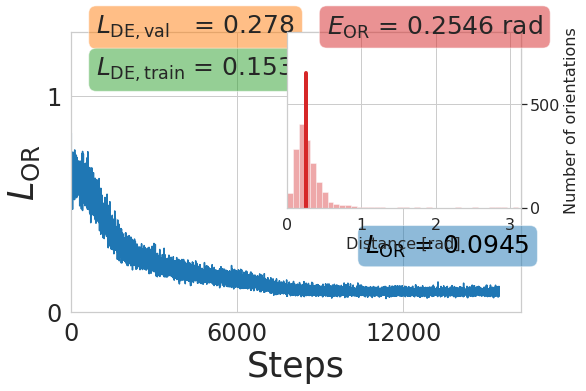

In [164]:
tick_size = 24
tick_size_small = 16
label_size = 35
textbox_size=25
label_size_small = 16

props1 = dict(boxstyle='round', facecolor=TRAIN_COLOR, alpha=0.5)
props2 = dict(boxstyle='round', facecolor=VAL_COLOR, alpha=0.5)


fig = plt.figure(figsize=(8, 5))
ax1 = fig.add_axes([0.11, 0.2, 0.78, 0.78])
ax2 = fig.add_axes([0.484, 0.49, 0.406, 0.49], facecolor="white")

ax1.plot(losses_plot, c=TEST_COLOR_LOR) 
ax1.set_xlabel("Steps", fontsize=label_size)
ax1.set_ylabel("$L_\mathrm{OR}$", fontsize=label_size)

ax1.set_xlim(0)
ax1.set_ylim(0,1.3)
ax1.xaxis.set_major_locator(plt.MaxNLocator(3))
ax1.yaxis.set_major_locator(plt.MaxNLocator(1))

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.5)
# place a text box in upper left in axes coords
ax1.text(0.42, 0.16, "$L_\mathrm{OR}$ = "+f"{np.mean(losses_plot[-10:]):.4f}", color="black", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
ax1.tick_params(axis='both', which='major', labelsize=tick_size)

### histogram
ax2.set_xlim(0, np.pi);ax2.set_ylim(0, 850)
# plot histogram
s = sns.distplot(d2, kde=False, bins=40, ax=ax2, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
# plot median line
ax2.plot([np.median(d2)]*max_count, np.linspace(0, 650,max_count), c=TEST_COLOR_EOR, lw=4)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_xlabel("Distance [rad]", fontsize=label_size_small)
ax2.set_ylabel("Number of orientations", fontsize=label_size_small)
# We change the fontsize of minor ticks label 
props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax2.text(0.355, 0.73, "$E_\mathrm{OR}$ = "+f"{np.median(d2):.4f} rad", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
ax2.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
ax2.yaxis.set_major_locator(plt.MaxNLocator(2))
ax2.tick_params(axis='both', which='major', labelsize=tick_size_small)

ax1.text(-0.034, 0.73, "$L_\mathrm{DE, val}$   = "+f"{0.2780:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
ax1.text(-0.034, 0.62, "$L_\mathrm{DE, train}$ = "+f"{0.1535:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)


# tightlayout does not work here
plt.savefig(f"{OUTPUT_DATA_DIR}/5j0n_fullcvg_uniformS2_noise16_ar_aa.pdf")
plt.show();

---

## `5a1a` Quarter Coverage Uniform S2 sampling with Noise 0 LATEST

In [ ]:
# results_pipeline_5a1a_quartercov_uniformS2_noise0

In [172]:
losses_plot = np.loadtxt(f'{INPUT_DATA_DIR}/5a1a_LOR_quartercov_uniformS2_noise0_LAST.csv')
d2 = np.loadtxt(f'{INPUT_DATA_DIR}/5a1a_EOR_quartercov_uniformS2_noise0_LAST.csv')
# loss_last= 0.1264

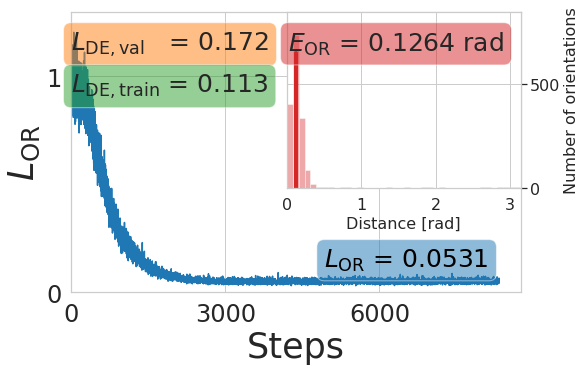

In [175]:
tick_size = 24
tick_size_small = 16
label_size = 35
textbox_size=25
label_size_small = 16

props1 = dict(boxstyle='round', facecolor=TRAIN_COLOR, alpha=0.5)
props2 = dict(boxstyle='round', facecolor=VAL_COLOR, alpha=0.5)

fig = plt.figure(figsize=(8, 5))
ax1 = fig.add_axes([0.11, 0.2, 0.78, 0.78])
ax2 = fig.add_axes([0.484, 0.49, 0.406, 0.49], facecolor="white")

ax1.plot(losses_plot, c=TEST_COLOR_LOR) 
ax1.set_xlabel("Steps", fontsize=label_size)
ax1.set_ylabel("$L_\mathrm{OR}$", fontsize=label_size)

ax1.set_xlim(0)
ax1.set_ylim(0,1.3)
ax1.xaxis.set_major_locator(plt.MaxNLocator(3))
ax1.yaxis.set_major_locator(plt.MaxNLocator(1))

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.5)
# place a text box in upper left in axes coords
ax1.text(0.42, 0.16, "$L_\mathrm{OR}$ = "+f"{np.mean(losses_plot[-10:]):.4f}", color="black", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
ax1.tick_params(axis='both', which='major', labelsize=tick_size)

### histogram
ax2.set_xlim(0, np.pi);ax2.set_ylim(0, 850)
# plot histogram
s = sns.distplot(d2, kde=False, bins=40, ax=ax2, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
ax2.plot([np.median(d2)]*max_count, np.linspace(0, 650,max_count), c=TEST_COLOR_EOR, lw=4)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_xlabel("Distance [rad]", fontsize=label_size_small)
ax2.set_ylabel("Number of orientations", fontsize=label_size_small)
# We change the fontsize of minor ticks label 
props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax2.text(0.355, 0.73, "$E_\mathrm{OR}$ = "+f"{np.median(d2):.4f} rad", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
ax2.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
ax2.yaxis.set_major_locator(plt.MaxNLocator(2))
ax2.tick_params(axis='both', which='major', labelsize=tick_size_small)

ax1.text(-0.034, 0.73, "$L_\mathrm{DE, val}$   = "+f"{0.172:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
ax1.text(-0.034, 0.62, "$L_\mathrm{DE, train}$ = "+f"{0.113:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)


# tightlayout does not work here
plt.savefig(f"{OUTPUT_DATA_DIR}/5a1a_quartercov_uniformS2_noise0_LAST_ar_aa.pdf")
plt.show();

---

## `5a1a` Quarter Coverage Uniform S2 sampling with Noise 16 LATEST

In [ ]:
# results_pipeline_5a1a_quartercov_uniformS2_noise16

In [237]:
losses_plot = np.loadtxt(f'{INPUT_DATA_DIR}/5a1a_LOR_quartercov_uniformS2_noise16_LAST.csv')
d2 = np.loadtxt(f'{INPUT_DATA_DIR}/5a1a_EOR_quartercov_uniformS2_noise16_LAST.csv')
loss_last= 0.1347

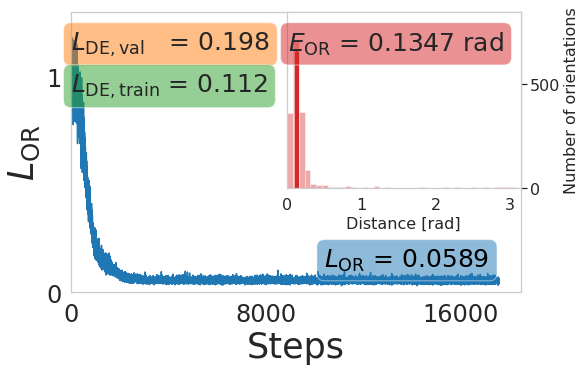

In [238]:
tick_size = 24
tick_size_small = 16
label_size = 35
textbox_size=25
label_size_small = 16

props1 = dict(boxstyle='round', facecolor=TRAIN_COLOR, alpha=0.5)
props2 = dict(boxstyle='round', facecolor=VAL_COLOR, alpha=0.5)

fig = plt.figure(figsize=(8, 5))
ax1 = fig.add_axes([0.11, 0.2, 0.78, 0.78])
ax2 = fig.add_axes([0.484, 0.49, 0.406, 0.49], facecolor="white")

ax1.plot(losses_plot, c=TEST_COLOR_LOR) 
ax1.set_xlabel("Steps", fontsize=label_size)
ax1.set_ylabel("$L_\mathrm{OR}$", fontsize=label_size)

ax1.set_xlim(0)
ax1.set_ylim(0,1.3)
ax1.xaxis.set_major_locator(plt.MaxNLocator(3))
ax1.yaxis.set_major_locator(plt.MaxNLocator(1))

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.5)
# place a text box in upper left in axes coords
ax1.text(0.42, 0.16, "$L_\mathrm{OR}$ = "+f"{np.mean(losses_plot[-1:]):.4f}", color="black", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
ax1.tick_params(axis='both', which='major', labelsize=tick_size)

### histogram
ax2.set_xlim(0, np.pi);ax2.set_ylim(0, 850)
# plot histogram
s = sns.distplot(d2, kde=False, bins=40, ax=ax2, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
ax2.plot([np.median(d2)]*max_count, np.linspace(0, 650,max_count), c=TEST_COLOR_EOR, lw=4)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_xlabel("Distance [rad]", fontsize=label_size_small)
ax2.set_ylabel("Number of orientations", fontsize=label_size_small)
# We change the fontsize of minor ticks label 
props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax2.text(0.355, 0.73, "$E_\mathrm{OR}$ = "+f"{np.median(d2):.4f} rad", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
ax2.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
ax2.yaxis.set_major_locator(plt.MaxNLocator(2))
ax2.tick_params(axis='both', which='major', labelsize=tick_size_small)

ax1.text(-0.034, 0.73, "$L_\mathrm{DE, val}$   = "+f"{0.198:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
ax1.text(-0.034, 0.62, "$L_\mathrm{DE, train}$ = "+f"{0.1124:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)


# tightlayout does not work here
plt.savefig(f"{OUTPUT_DATA_DIR}/5a1a_quartercov_uniformS2_noise16_LAST_ar_aa.pdf")
plt.show();

---

## `5j0n` Orientation Recovery Loss $L_{OR}$ Full Coverage - Uniform Angles

In [274]:
losses_plot = np.loadtxt(f'{INPUT_DATA_DIR}/5j0n_LOR_fullcvg_uniformEuler.csv')
d2 = np.loadtxt(f'{INPUT_DATA_DIR}/5j0n_EOR_fullcvg_uniformEuler.csv')
loss_last= 0.22973200165467145

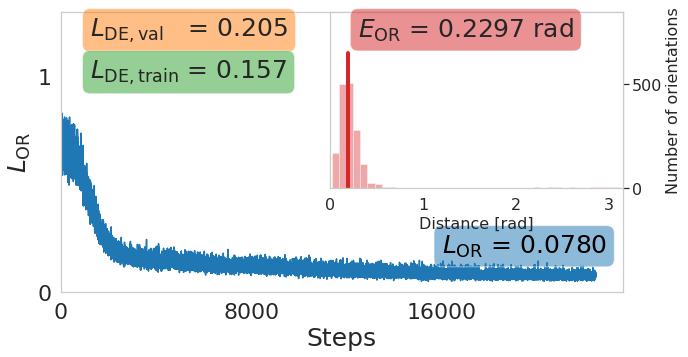

In [279]:
tick_size = 22
tick_size_small = 16
label_size = 25
textbox_size=25
label_size_small = 16

props1 = dict(boxstyle='round', facecolor=TRAIN_COLOR, alpha=0.5)
props2 = dict(boxstyle='round', facecolor=VAL_COLOR, alpha=0.5)


fig = plt.figure(figsize=(10, 5))
#fig = plt.figure(figsize=(8.2, 3))
#fig.patch.set_facecolor('white') 
#plt.rcParams['figure.facecolor'] = 'white'
ax1 = fig.add_axes([0.11, 0.2, 0.78, 0.78])
ax2 = fig.add_axes([0.484, 0.49, 0.406, 0.49], facecolor="white")

ax1.plot(losses_plot, c=TEST_COLOR_LOR) 
ax1.set_xlabel("Steps", fontsize=label_size)
ax1.set_ylabel("$L_\mathrm{OR}$", fontsize=label_size)

ax1.set_xlim(0)
ax1.set_ylim(0,1.3)
#ax1.patch.set_facecolor("white")
ax1.xaxis.set_major_locator(plt.MaxNLocator(3))
ax1.yaxis.set_major_locator(plt.MaxNLocator(1))

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.5)
# place a text box in upper left in axes coords
ax1.text(0.63, 0.16, "$L_\mathrm{OR}$ = "+f"{np.mean(losses_plot[-5:]):.4f}", color="black", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
ax1.tick_params(axis='both', which='major', labelsize=tick_size)

### histogram
ax2.set_xlim(0, np.pi);ax2.set_ylim(0, 850)
# plot histogram
s = sns.distplot(d2, kde=False, bins=40, ax=ax2, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
# plot median line
ax2.plot([np.median(d2)]*max_count, np.linspace(0, 650,max_count), c=TEST_COLOR_EOR, lw=4)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_xlabel("Distance [rad]", fontsize=label_size_small)
ax2.set_ylabel("Number of orientations", fontsize=label_size_small)
# We change the fontsize of minor ticks label 
props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax2.text(0.48, 0.73, "$E_\mathrm{OR}$ = "+f"{loss_last:.4f} rad", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
#ax2.patch.set_facecolor("black")
#fig.patch.set_facecolor('white')
ax2.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
ax2.yaxis.set_major_locator(plt.MaxNLocator(2))
ax2.tick_params(axis='both', which='major', labelsize=tick_size_small)

ax1.text(0, 0.73, "$L_\mathrm{DE, val}$   = "+f"{0.2047:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
ax1.text(0, 0.62, "$L_\mathrm{DE, train}$ = "+f"{0.1568:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)


# tightlayout does not work here
plt.savefig(f"{OUTPUT_DATA_DIR}/5j0n_ar_aa_fullcvg_smaller.pdf")
plt.show();

---

## `5a1a` Quarter Coverage Uniform S2 sampling with Perfect distances

In [256]:
# results_pipeline_5a1a_quartercov_uniformS2_noise0_PERFECT

In [257]:
projections_filename = f"{INPUT_DATA_DIR}/results_pipeline_5a1a_quartercov_uniformS2_halfInplane/5a1a_uniform_ProjectionsAngles_ProjNber5000_AngCoverage1.0,0.4,1.0_AngShift0.0,0.0,0.0.h5"

data = h5py.File(projections_filename, 'r')
angles_true = data['Angles']

data = np.load(f"{INPUT_DATA_DIR}/results_pipeline_5a1a_quartercov_uniformS2_halfInplane/5j0n_siamese_idx.npz")
train_idx, val_idx, test_idx = data['arr_0'], data['arr_1'], data['arr_2']

data = np.load(f"{INPUT_DATA_DIR}/results_pipeline_5a1a_quartercov_uniformS2_halfInplane/angle_recovery.npz")
q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

In [258]:
losses_plot = np.loadtxt(f'{INPUT_DATA_DIR}/5a1a_LOR_quartercov_uniformS2_perfect.csv')
d2 = np.loadtxt(f'{INPUT_DATA_DIR}/5a1a_EOR_quartercov_uniformS2_perfect.csv')
# loss_last= 0.0037

m= [1.0, 1.0, 1.0, -1.0] 
trajectory_first= [3.28324785 ,4.82066944 ,3.67273171 ,4.30051501, 6.20146876 ,0.90551384] 
loss_first= 2.0940179860519117 
trajectory_last= [-6.42346128 , 9.8084988  , 5.22514841 ,37.89870159, 41.51883345 , 0.18513396] 
loss_last= 0.0028296679100272

In [259]:
tick_size = 25
label_size = 30
textbox_size=32

In [260]:
# # Distance count subplot (full)
q_predicted_rot = np.squeeze(update_quaternion(m, [tf.Variable(trajectory_first)], q_predicted))
_d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
#save just the data for the plot, not the whole pipeline
np.savetxt(f'{INPUT_DATA_DIR}/5a1a_EOR_beforeaa.csv', _d2)

In [261]:
_d2 = np.loadtxt(f'{INPUT_DATA_DIR}/5a1a_EOR_beforeaa.csv')

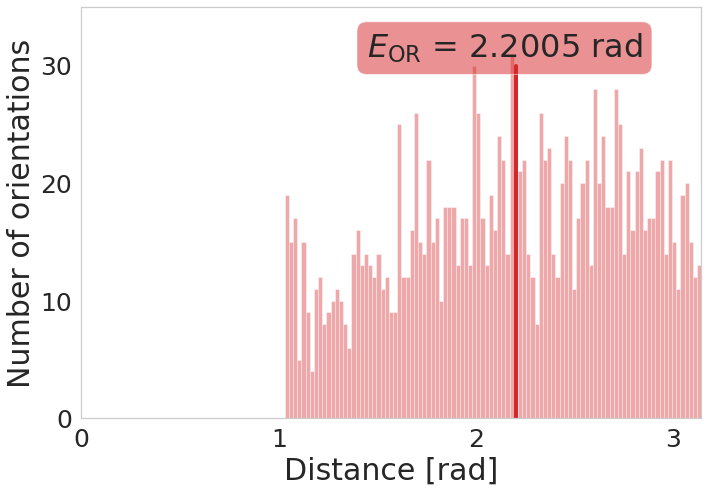

In [262]:
fig, ax = plt.subplots(figsize=(10,7))

ax.set_xlim(0, np.pi)
ax.set_ylim(0, 35)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(_d2, kde=False, bins=100, ax=ax, color=TEST_COLOR_EOR)
max_count = 31  #int(max([h.get_height() for h in s.patches]))
ax.set_ylim((0, 35))
ax.plot([np.median(_d2)]*max_count, np.arange(0, max_count,1), c=TEST_COLOR_EOR, lw=4)
plt.xlabel("Distance [rad]", fontsize=label_size)
plt.ylabel("Number of orientations", fontsize=label_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=tick_size)
ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[1]))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))

props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.46, 0.94, r"$E_\mathrm{OR}$ = "+f"{np.median(_d2):.4f} rad", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DATA_DIR}/BeforeAA.pdf")

In [263]:
from cryoem.rotation_matrices import RotationMatrix

def plot_only_selected_in_euclidean_space(angles, angles_true, selected, connection=True):
    ipv.clear()
    aps = RotationMatrix(np.take(angles, selected, axis=0))[:, :3]
    ats = RotationMatrix(np.take(angles_true, selected, axis=0))[:, :3]
    
    if connection:
        connections = np.empty((len(selected)*2, 2, 3))
        connections[:] = np.nan
        connections[::2] = np.stack([ats, aps], axis=1)
        ipv.plot(connections[:, :, 0].flatten(), connections[:, :, 1].flatten(), connections[:, :, 2].flatten(), color="red", lynestyle="--")

    ipv.scatter(ats[:, 0], ats[:, 1], ats[:, 2],
                marker="sphere", color="green", size=1)
    ipv.scatter(aps[:, 0], aps[:, 1], aps[:, 2],
                marker="sphere", color="red", size=1)
    
    ipv.xlim(-1, 1)
    ipv.ylim(-1, 1)
    ipv.zlim(-1, 1)
    ipv.view(90, 45,1.5)
    ipv.show()

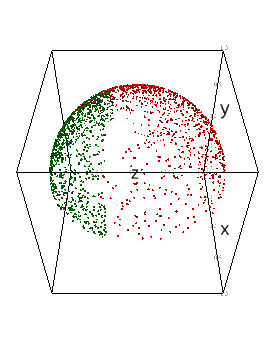

In [264]:
#from cryoem.plots import plot_rays, plot_only_selected_in_euclidean_space

angles_pred = quaternion2euler(q_predicted_rot)

#plot_rays(angles_true, indices=range(100))
plot_only_selected_in_euclidean_space(angles_pred, angles_true, selected=range(1000), connection=False)

In [265]:
ipv.screenshot()

Output()

In [266]:
# # Distance count subplot (full)
q_predicted_rot = np.squeeze(update_quaternion(m, [tf.Variable(trajectory_last)], q_predicted))
d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
#save just the data for the plot, not the whole pipeline
np.savetxt(f'{INPUT_DATA_DIR}/5a1a_EOR_afteraa.csv', d2)

In [267]:
d2 = np.loadtxt(f'{INPUT_DATA_DIR}/5a1a_EOR_afteraa.csv')

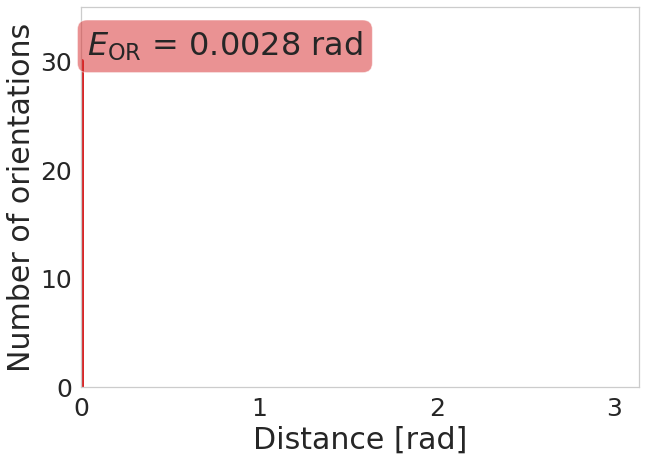

In [268]:
fig, ax = plt.subplots(figsize=(10,7))


ax.set_xlim(0, np.pi)
ax.set_ylim(0, 35)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=100, ax=ax, color=TEST_COLOR_EOR)
max_count = 31 #int(max([h.get_height() for h in s.patches]))
ax.set_ylim((0, 35))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c=TEST_COLOR_EOR, lw=4)
plt.xlabel("Distance [rad]", fontsize=label_size)
plt.ylabel("Number of orientations", fontsize=label_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=tick_size)
ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[1]))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))

props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.01, 0.94, r"$E_\mathrm{OR}$ = "+f"{np.median(d2):.4f} rad", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
plt.savefig(f"{OUTPUT_DATA_DIR}/AfterAA.pdf")

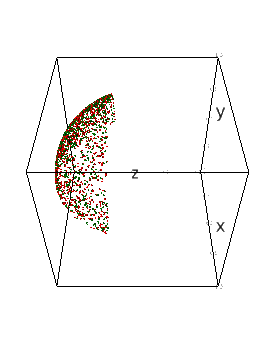

In [269]:
angles_pred = quaternion2euler(q_predicted_rot)
plot_only_selected_in_euclidean_space(angles_pred, angles_true, selected=range(1000), connection=False)

In [270]:
ipv.screenshot()

Output()

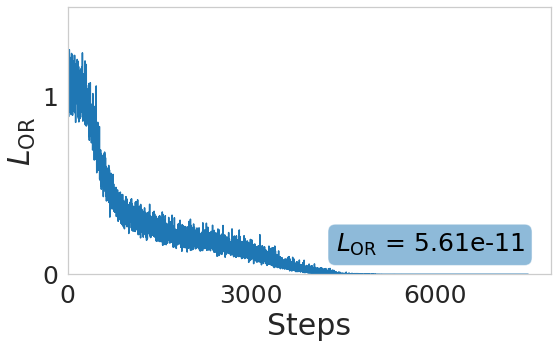

In [272]:
tick_size = 25
label_size = 30
textbox_size=25
label_size_small = 17

props1 = dict(boxstyle='round', facecolor=TRAIN_COLOR, alpha=0.5)
props2 = dict(boxstyle='round', facecolor=VAL_COLOR, alpha=0.5)

fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.plot(losses_plot, c=TEST_COLOR_LOR) 
ax1.set_xlabel("Steps", fontsize=label_size)
ax1.set_ylabel("$L_\mathrm{OR}$", fontsize=label_size)

ax1.set_xlim(0)
ax1.set_ylim(0,1.5)
#ax1.patch.set_facecolor("white")
ax1.xaxis.set_major_locator(plt.MaxNLocator(3))
ax1.yaxis.set_major_locator(plt.MaxNLocator(steps=[1]))

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.5)
# place a text box in upper left in axes coords
ax1.text(0.44, 0.14, "$L_\mathrm{OR}$ = "+f"{np.mean(losses_plot[-10:]):.2e}", color="black", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
ax1.tick_params(axis='both', which='major', labelsize=tick_size)

# tightlayout does not work here
plt.tight_layout()
plt.savefig(f"{OUTPUT_DATA_DIR}/5a1a_quartercov_uniformS2_perfect_ar_aa.pdf")
plt.show();

---

## `5j0n` Projections with Perturbations

In [203]:
projections_filename = "5j0n_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

data = h5py.File(os.path.join(INPUT_DATA_DIR, projections_filename), 'r')
projections = data['Projections']
angles = data['Angles']

In [211]:
from cryoem.plots import plot_projection
from cryoem.helpers import train_val_test_split, projections_preprocessing

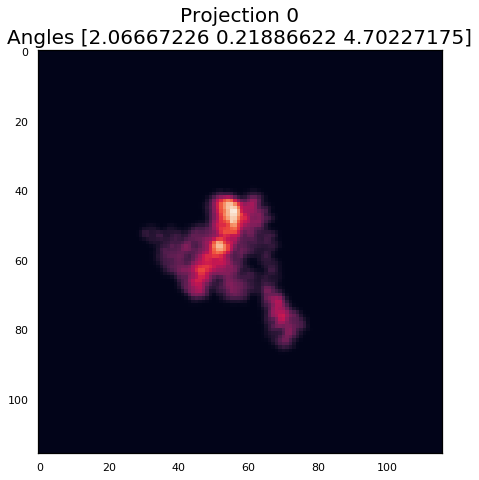

In [219]:
pid = 0
plot_projection(projections[pid], f'Projection {pid}\nAngles {angles[pid]}', colorbar=False)

In [213]:
settings = dict(
    noise={"variance":16.0},
    shift={"left_limit":-0.01,
           "peak_limit":0,
           "right_limit":0.01},
    channels="gray"
)

In [215]:
X, y = projections_preprocessing(projections, angles, settings=settings)

Image shape: (116, 116)
Data Type: float32
***
Mean: 0.262 | Std: 4.135
Min:  -22.051 | Max: 28.363
Mean: -0.000 | Std: 1.000
Min:  -5.396 | Max: 6.796


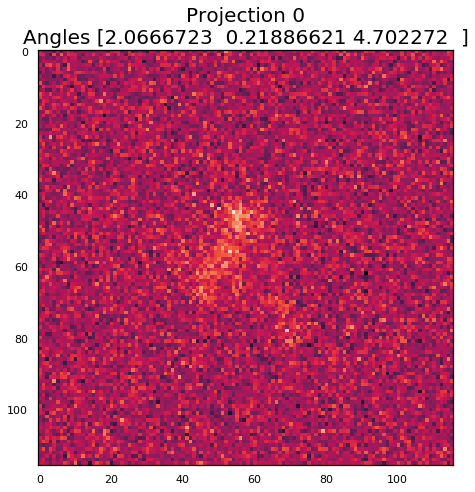

In [218]:
pid = 0
plot_projection(X[pid].squeeze(), f'Projection {pid}\nAngles {y[pid]}', colorbar=False)

---

## Fourier shell correlation (FSCs)

In [193]:
label_size = 34
legend_size=24
tick_size=28
textbox_size = 32

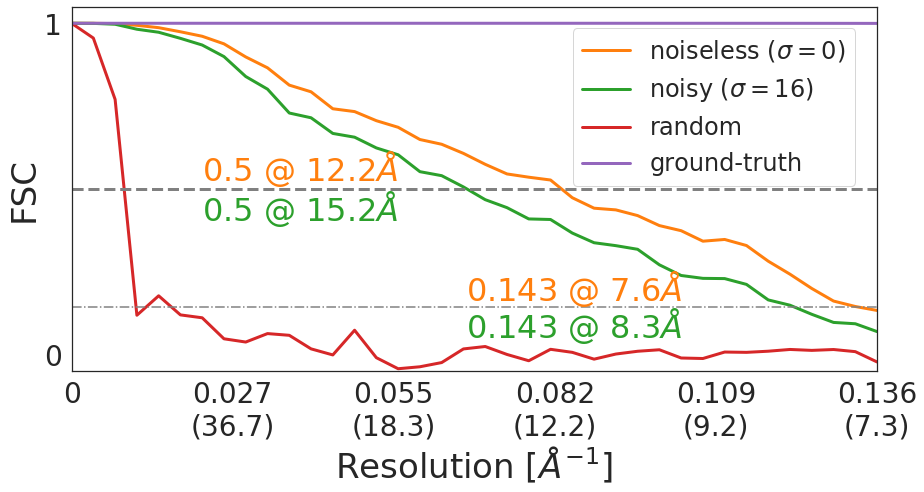

In [197]:
from xml.dom import minidom
legend_size=24
# parse an xml file by name
mydoc = minidom.parse(f'{INPUT_DATA_DIR}/5j0n_fullcvg_uniformS2_noise0_FSC_apr_init.xml')
X = mydoc.getElementsByTagName('x')
Y = mydoc.getElementsByTagName('y')
x1 = list(map(lambda i: float(i.firstChild.data), X))
y1 = list(map(lambda i: float(i.firstChild.data), Y))
# parse an xml file by name
mydoc = minidom.parse(f'{INPUT_DATA_DIR}/5j0n_fullcvg_uniformS2_noise16_FSC_apr_init.xml')
X = mydoc.getElementsByTagName('x')
Y = mydoc.getElementsByTagName('y')
x2 = list(map(lambda i: float(i.firstChild.data), X))
y2 = list(map(lambda i: float(i.firstChild.data), Y))
# parse an xml file by name
mydoc = minidom.parse(f'{INPUT_DATA_DIR}/5j0n_fullcvg_uniformS2_noise0_FSC_rand_init.xml')
X = mydoc.getElementsByTagName('x')
Y = mydoc.getElementsByTagName('y')
x3 = list(map(lambda i: float(i.firstChild.data), X))
y3 = list(map(lambda i: float(i.firstChild.data), Y))
# parse an xml file by name
mydoc = minidom.parse(f'{INPUT_DATA_DIR}/5j0n_fullcvg_uniformS2_noise0_FSC_gt_init.xml')
X = mydoc.getElementsByTagName('x')
Y = mydoc.getElementsByTagName('y')
x4 = list(map(lambda i: float(i.firstChild.data), X))
y4 = list(map(lambda i: float(i.firstChild.data), Y))



fig, ax1 = plt.subplots(figsize=(13, 7))

c1 = "gray"#u'#ff7f0e'
c2 = "gray"#u'#2ca02c'

color1 = u'#ff7f0e'
color2 = u'#2ca02c'
color3 = u'#d62728'
color4 = u'#9467bd'

ax1.plot(x1, y1, c=color1, label="noiseless ($\sigma=0$)", lw=3) 
ax1.plot(x2, y2, c=color2, label="noisy ($\sigma=16$)", lw=3) 
ax1.plot(x3, y3, c=color3, label="random", lw=3) 
ax1.plot(x4, y4, c=color4, label="ground-truth", lw=3) 
ax1.set_xlabel(r"Resolution [$\AA^{-1}$]", fontsize=label_size)
ax1.set_ylabel("FSC", fontsize=label_size)
ax1.plot(x1, np.ones(len(x1))*0.5, ls="--", lw=3,color=c1)
ax1.plot(x1, np.ones(len(x1))*0.143, ls="-.", color=c2)

ax1.set_ylim(-0.05,1.05);ax1.set_xlim(0,max(x1))

# TODO:
ticks = np.linspace(0, max(x1), 6)
labels = list(map(lambda x: f"{x:.3f}\n({1/x:.1f})" if x!=0 else "0", ticks))

ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(steps=[1]))
ax1.tick_params(axis='both', which='major', labelsize=tick_size)
plt.xticks(ticks, labels)  # Set text labels and properties.

# TODO:
ax1.text(0.15, 0.61, r" 0.5 @ 12.2$\AA$", transform=ax1.transAxes, fontweight='medium', fontsize=textbox_size, verticalalignment='top', color=color1)
ax1.text(0.49, 0.28, r"0.143 @ 7.6$\AA$", transform=ax1.transAxes, fontweight='medium', fontsize=textbox_size, verticalalignment='top', color=color1)
ax1.text(0.15, 0.5, r" 0.5 @ 15.2$\AA$", transform=ax1.transAxes, fontweight='medium', fontsize=textbox_size, verticalalignment='top', color=color2)
ax1.text(0.49, 0.18, r"0.143 @ 8.3$\AA$", transform=ax1.transAxes, fontweight='medium', fontsize=textbox_size, verticalalignment='top', color=color2)


plt.tight_layout()
plt.legend(fontsize=legend_size, borderaxespad=0.9)
plt.savefig(f"{OUTPUT_DATA_DIR}/5j0n_fullcvg_uniformS2_FSC_apr_init_customFSC2.pdf")

legend_size=24

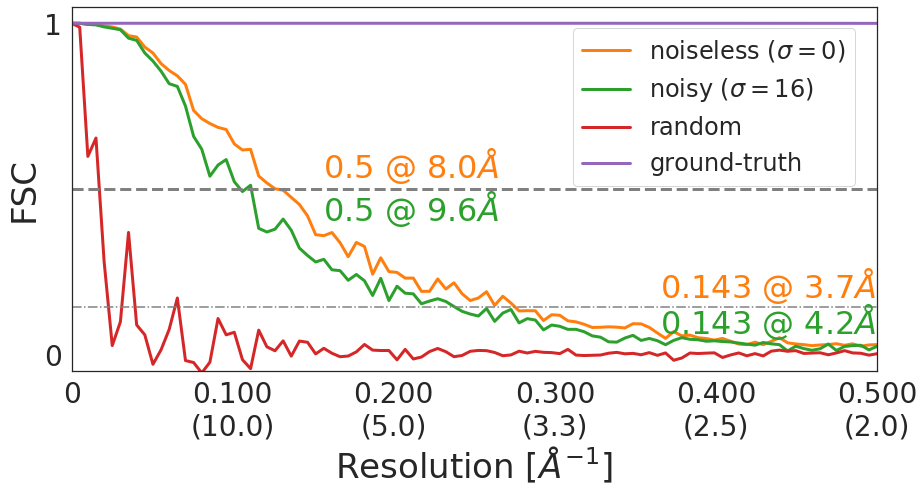

In [199]:
from xml.dom import minidom
legend_size=24
# parse an xml file by name
mydoc = minidom.parse(f'{INPUT_DATA_DIR}/5a1a_quartercov_uniformS2_noise0_FSC_apr_init2.xml')
X = mydoc.getElementsByTagName('x')
Y = mydoc.getElementsByTagName('y')
x1 = list(map(lambda i: float(i.firstChild.data), X))
y1 = list(map(lambda i: float(i.firstChild.data), Y))
# parse an xml file by name
mydoc = minidom.parse(f'{INPUT_DATA_DIR}/5a1a_quartercov_uniformS2_noise16_FSC_apr_init.xml')
X = mydoc.getElementsByTagName('x')
Y = mydoc.getElementsByTagName('y')
x2 = list(map(lambda i: float(i.firstChild.data), X))
y2 = list(map(lambda i: float(i.firstChild.data), Y))
# parse an xml file by name
mydoc = minidom.parse(f'{INPUT_DATA_DIR}/5a1a_quartercvg_uniformS2_noise0_FSC_rand_init.xml')
X = mydoc.getElementsByTagName('x')
Y = mydoc.getElementsByTagName('y')
x3 = list(map(lambda i: float(i.firstChild.data), X))
y3 = list(map(lambda i: float(i.firstChild.data), Y))
# parse an xml file by name
mydoc = minidom.parse(f'{INPUT_DATA_DIR}/5a1a_quartercvg_uniformS2_noise0_FSC_gt_init.xml')
X = mydoc.getElementsByTagName('x')
Y = mydoc.getElementsByTagName('y')
x4 = list(map(lambda i: float(i.firstChild.data), X))
y4 = list(map(lambda i: float(i.firstChild.data), Y))



fig, ax1 = plt.subplots(figsize=(13, 7))

c1 = "gray"#u'#ff7f0e'
c2 = "gray"#u'#2ca02c'

color1 = u'#ff7f0e'
color2 = u'#2ca02c'
color3 = u'#d62728'
color4 = u'#9467bd'

ax1.plot(x1, y1, c=color1, label="noiseless ($\sigma=0$)", lw=3) 
ax1.plot(x2, y2, c=color2, label="noisy ($\sigma=16$)", lw=3) 
ax1.plot(x3, y3, c=color3, label="random", lw=3) 
ax1.plot(x4, y4, c=color4, label="ground-truth", lw=3) 
ax1.set_xlabel(r"Resolution [$\AA^{-1}$]", fontsize=label_size)
ax1.set_ylabel("FSC", fontsize=label_size)
ax1.plot(x1, np.ones(len(x1))*0.5, ls="--", lw=3,color=c1)
ax1.plot(x1, np.ones(len(x1))*0.143, ls="-.", color=c2)

ax1.set_ylim(-0.05,1.05);ax1.set_xlim(0,max(x1))


# TODO:
ticks = np.linspace(0, max(x1), 6)
labels = list(map(lambda x: f"{x:.3f}\n({1/x:.1f})" if x!=0 else "0", ticks))

ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(steps=[1]))
ax1.tick_params(axis='both', which='major', labelsize=tick_size)
plt.xticks(ticks, labels)  # Set text labels and properties.

# TODO:
ax1.text(0.3, 0.62, r" 0.5 @ 8.0$\AA$", transform=ax1.transAxes, fontweight='medium', fontsize=textbox_size, verticalalignment='top', c=color1)
ax1.text(0.73, 0.29, r"0.143 @ 3.7$\AA$", transform=ax1.transAxes, fontweight='medium', fontsize=textbox_size, verticalalignment='top', c=color1)

ax1.text(0.3, 0.5, r" 0.5 @ 9.6$\AA$", transform=ax1.transAxes, fontweight='medium', fontsize=textbox_size, verticalalignment='top', c=color2)
ax1.text(0.73, 0.19, r"0.143 @ 4.2$\AA$", transform=ax1.transAxes, fontweight='medium', fontsize=textbox_size, verticalalignment='top', c=color2)


plt.tight_layout()
plt.legend(fontsize=legend_size, borderaxespad=0.9)
plt.savefig(f"{OUTPUT_DATA_DIR}/5a1a_quartercvg_uniformS2_noise0_FSC_apr_init_customFSC2.pdf")
legend_size=24

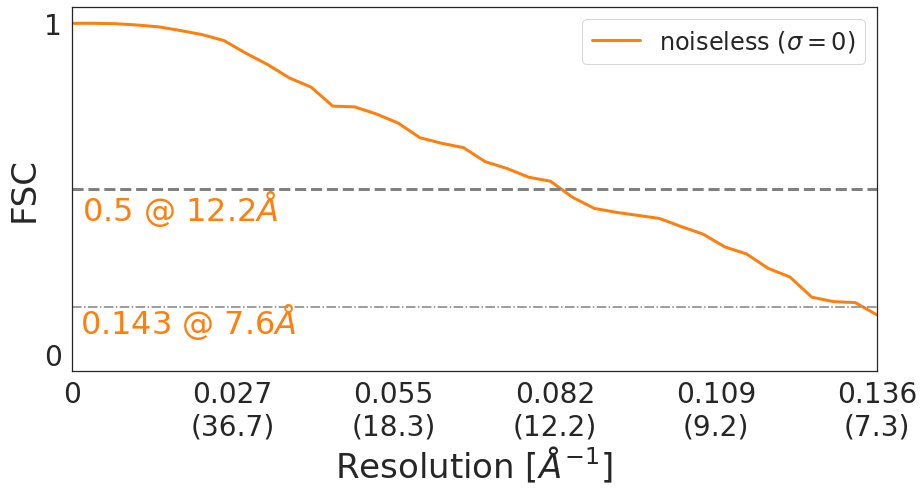

In [201]:
from xml.dom import minidom

# parse an xml file by name
mydoc = minidom.parse(f'{INPUT_DATA_DIR}/5j0n_fullcvg_noise0_FSC_apr_init.xml')

X = mydoc.getElementsByTagName('x')
Y = mydoc.getElementsByTagName('y')

x = list(map(lambda i: float(i.firstChild.data), X))
y = list(map(lambda i: float(i.firstChild.data), Y))


fig, ax1 = plt.subplots(figsize=(13, 7))

c1 = "gray"#u'#ff7f0e'
c2 = "gray"#u'#2ca02c'

ax1.plot(x, y, c=color1, label="noiseless ($\sigma=0$)", lw=3) 
ax1.set_xlabel(r"Resolution [$\AA^{-1}$]", fontsize=label_size)
ax1.set_ylabel("FSC", fontsize=label_size)
ax1.plot(x, np.ones(len(x))*0.5, ls="--", lw=3,color=c1)
ax1.plot(x, np.ones(len(x))*0.143, ls="-.", color=c2)

ax1.set_ylim(-0.05,1.05);ax1.set_xlim(0,max(x))

# TODO:
ticks = np.linspace(0, max(x), 6)
labels = list(map(lambda x: f"{x:.3f}\n({1/x:.1f})" if x!=0 else "0", ticks))

ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(steps=[1]))
ax1.tick_params(axis='both', which='major', labelsize=tick_size)
plt.xticks(ticks, labels)  # Set text labels and properties.

# TODO:
ax1.text(0, 0.5, r" 0.5 @ 12.2$\AA$", transform=ax1.transAxes, fontweight='medium', fontsize=textbox_size, verticalalignment='top', c=color1)
ax1.text(0.01, 0.19, r"0.143 @ 7.6$\AA$", transform=ax1.transAxes, fontweight='medium', fontsize=textbox_size, verticalalignment='top', c=color1)

plt.tight_layout()
plt.legend(fontsize=legend_size)
plt.savefig(f"{OUTPUT_DATA_DIR}/5j0n_fullcvg_noise0_FSC_apr_init_customFSC.pdf")
